In [1]:
from scipy import stats 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Epydemix import
import sys 
sys.path.append("../")
from epydemix.population import Population
from epydemix.epimodel import EpiModel, stochastic_simulation
from epydemix.plotting import plot_quantiles, plot_selected_quantiles, plot_posterior, plot_posterior_2d
from epydemix.calibration import calibration_top_perc, calibration_abc_smc

# Calibration

```epydemix``` currently supports three calibration methods: 
- ```calibration_top_perc```: this methods run a number of simulations and retain the top x%. This is the simpliest method, that allows to get results in the minimum amount of time, since the total number of simulations is set by the user
- ```calibration_rejection``` (not yet implemented): this method implement the simple rejection algorithm.
- ```calibration_abc_smc```: this is the most sophisticated method which implements the ABC-SMC algorithm. This method allows to achieve more accurate results, but it is more computationally expensive.


Below we explore how these methods work in practice. First, we import population data:

In [2]:
population = Population() 
population.load_population(population_name="Indonesia", path_to_data="../epydemix_data/")

And epidemiological data on which we want to calibrate the model. In particular we have two dataset: 
- data_I.csv: here the quantity of intereset is the number of individuals infectious at each time step (prevalence)

- data_incidence.csv: here the quantity of intereset is the number of new individuals infectious at each time step (incidence)

We use these two examples to show the flexibility of pur package to different type of data for calibration.

In [3]:
df_I = pd.read_csv("./data/data_I.csv")
df_incidence = pd.read_csv("./data/data_incidence.csv")

We first define model and priors, this step is common to all calibration methods:

In [6]:
# create model 
model = EpiModel(compartments=["S", "I", "R"])
model.add_parameter(parameters_dict={"beta": 0.04, "mu": 0.2})
model.add_transition(source="S", target="I", rate="beta", agent="I")
model.add_transition(source="I", target="R", rate="mu")

# initial conditions
S=population.Nk - np.ones(len(population.Nk))
I=np.ones(len(population.Nk))
R=np.zeros(len(population.Nk))

# simulation dates
steps = "daily"
start_date=df_I.date.values[0]
end_date=df_I.date.values[-1]
start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
simulation_dates = pd.date_range(start=start_date, end=end_date, freq="d").tolist()
model.compute_contact_reductions(population, simulation_dates)

# parameters
parameters = {"S": S, 
              "I": I, 
              "R": R, 
              "epimodel": model, 
              "dt": np.diff(simulation_dates)[0] / timedelta(days=1),
              "population": population, 
              "simulation_dates": simulation_dates}

# priors
priors = {"beta": stats.uniform(0.015, 0.025), "mu": stats.uniform(0.15, 0.25)}

## Top % Calibration

In [8]:
def post_processing_function(results, **parameters): 
    results.update({"data": results["I_total"]})
    return results

results = calibration_top_perc(simulation_function=stochastic_simulation, 
                               parameters=parameters,
                               priors=priors, 
                               data={"data": df_I["I"].values},
                               top_perc=0.05,
                               Nsim=1000,
                               post_processing_function=post_processing_function)

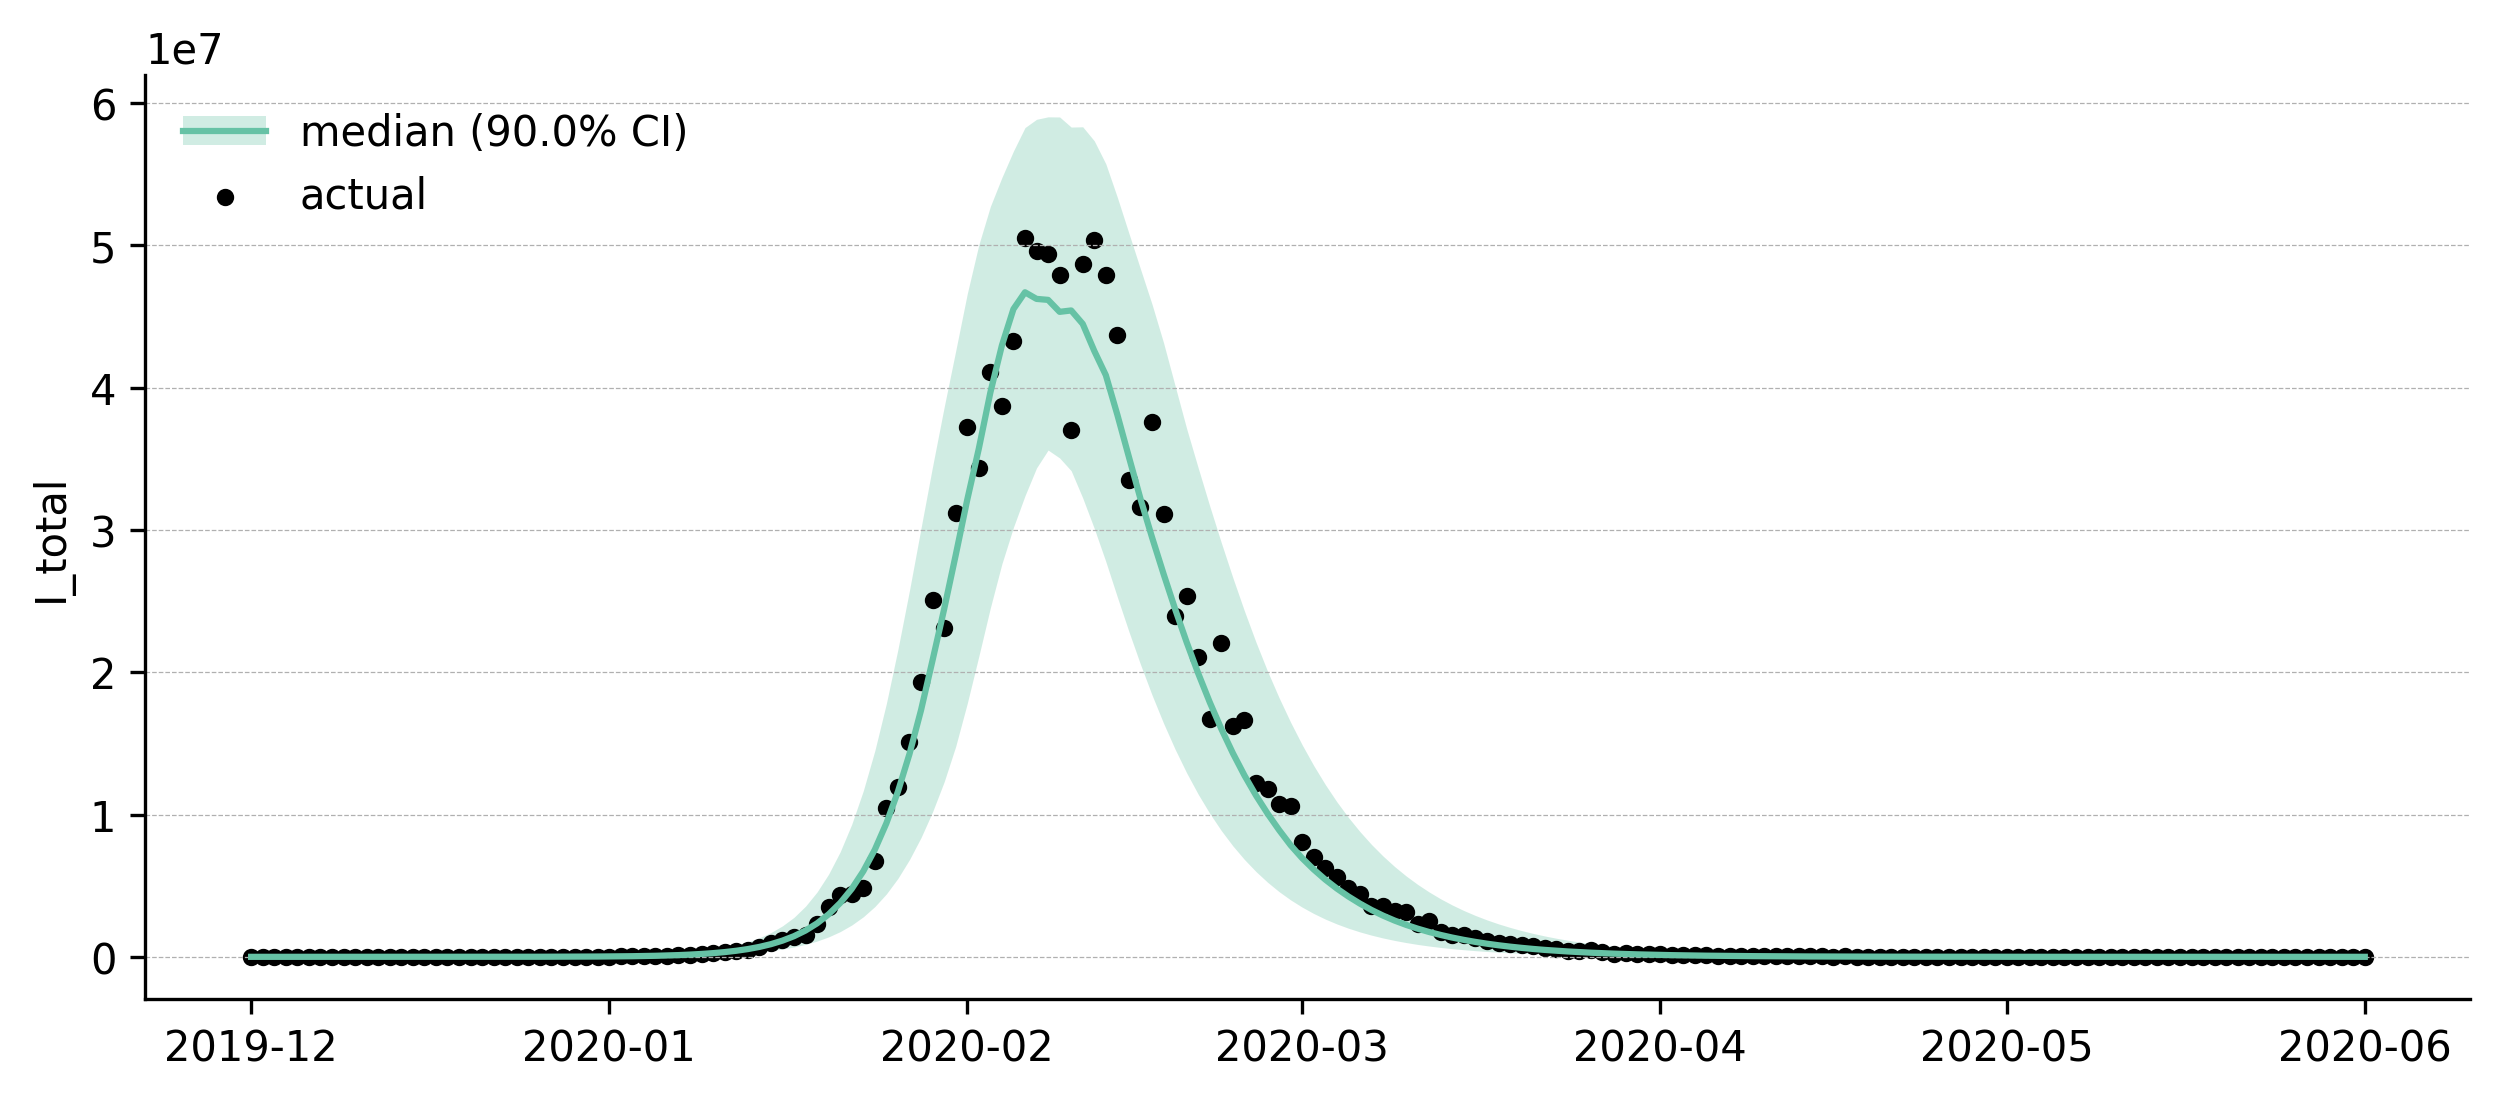

In [9]:
plot_selected_quantiles(results, ylabel="I_total")

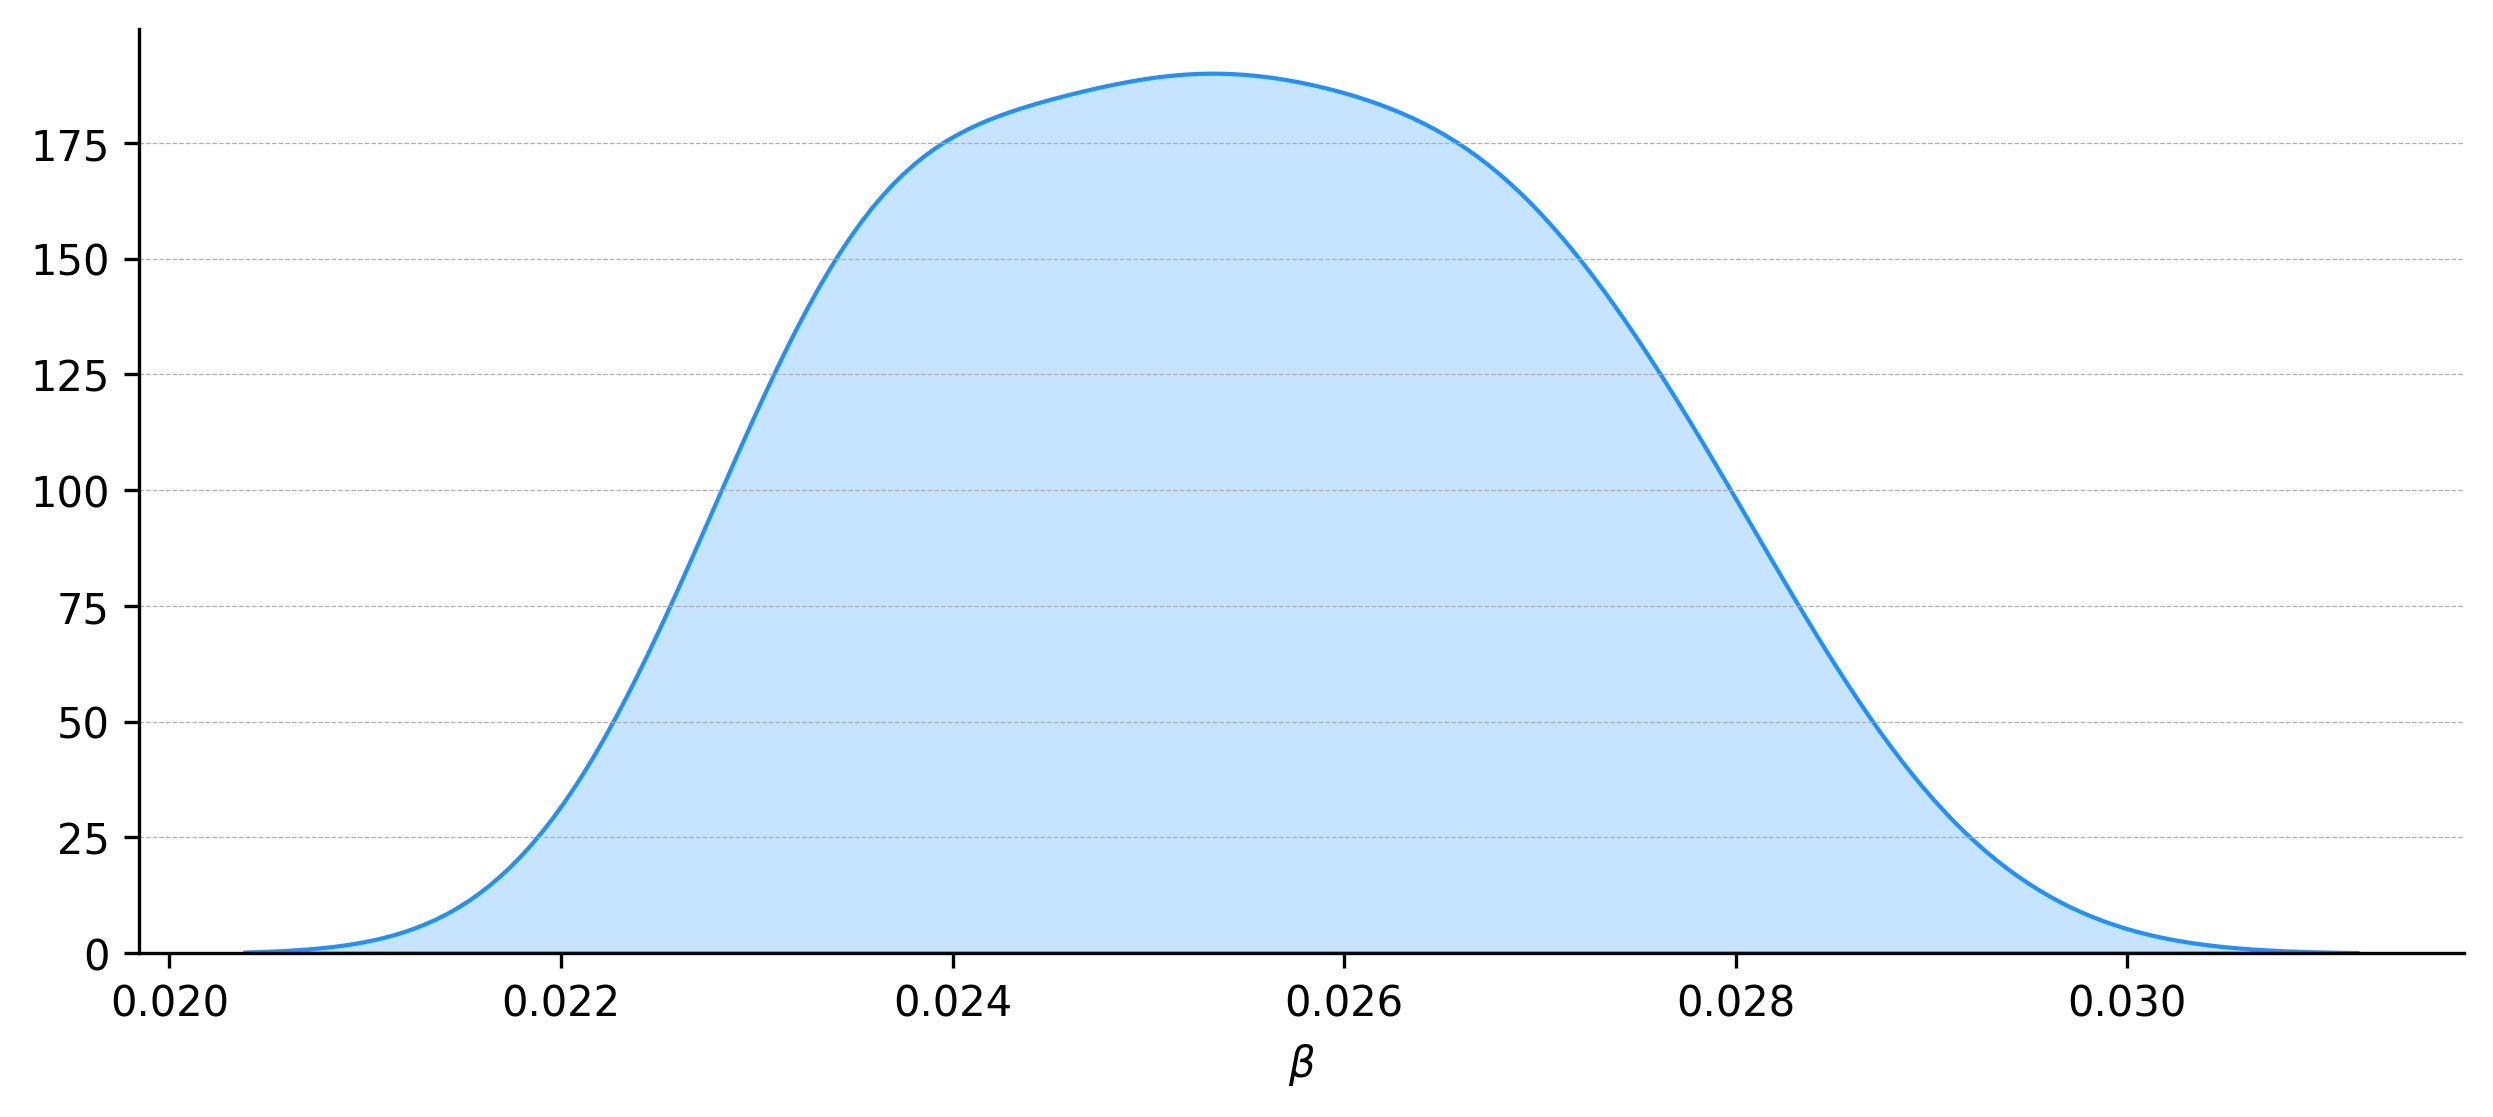

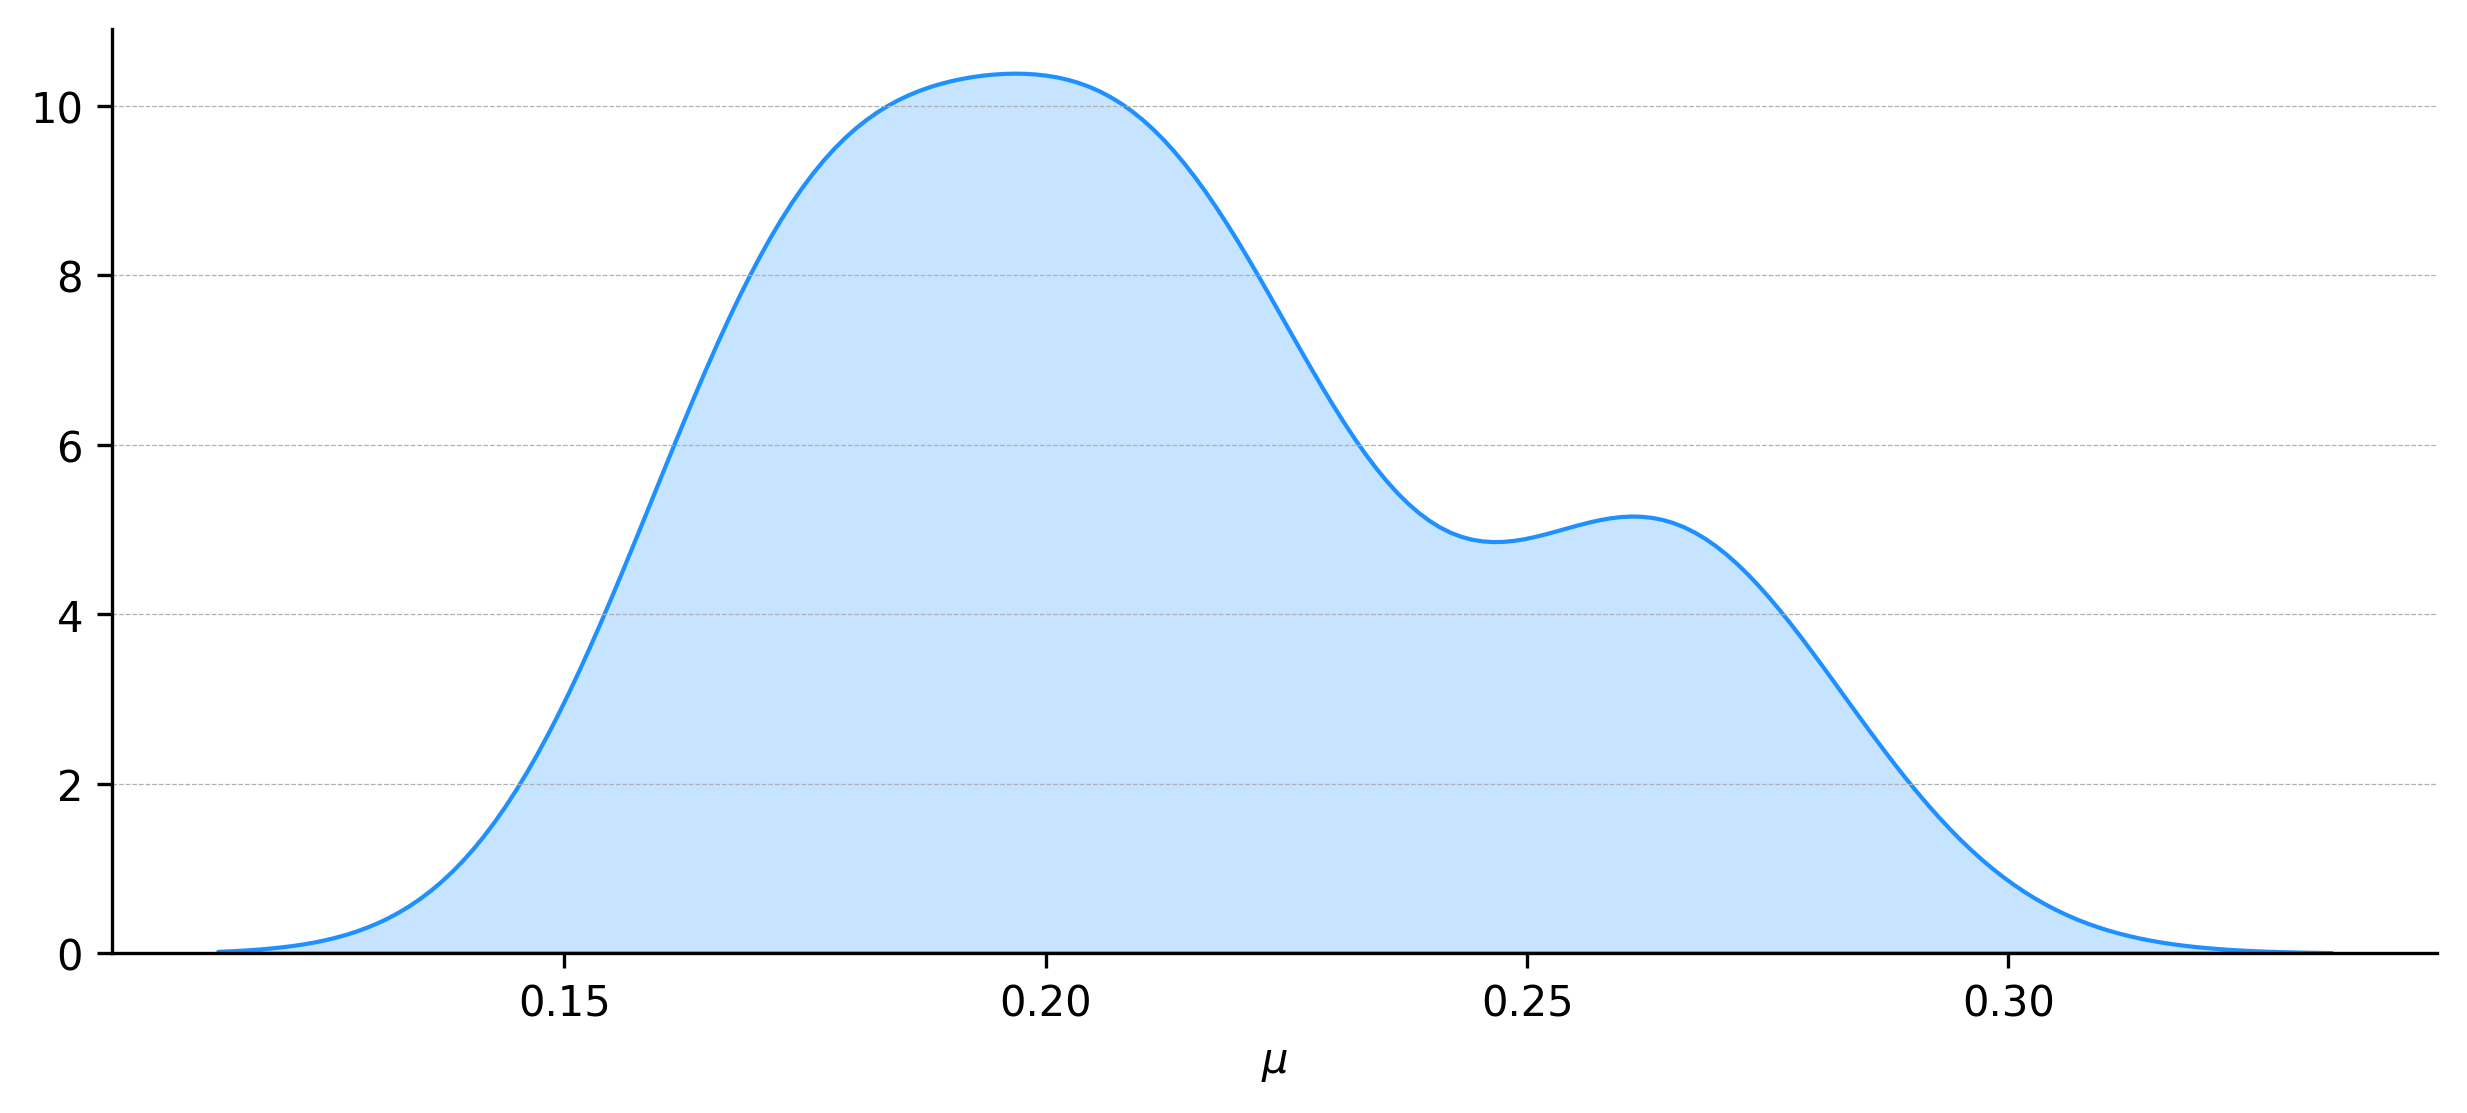

In [10]:
plot_posterior(results, "beta", kind="kde", prior_range=False, xlabel="$\\beta$")
plot_posterior(results, "mu", kind="kde", prior_range=False, xlabel="$\\mu$")

../epydemix/plotting.py:229: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_posterior, x=parameter_x, y=parameter_y, ax=ax, fill=True, palette=palette, **kwargs)


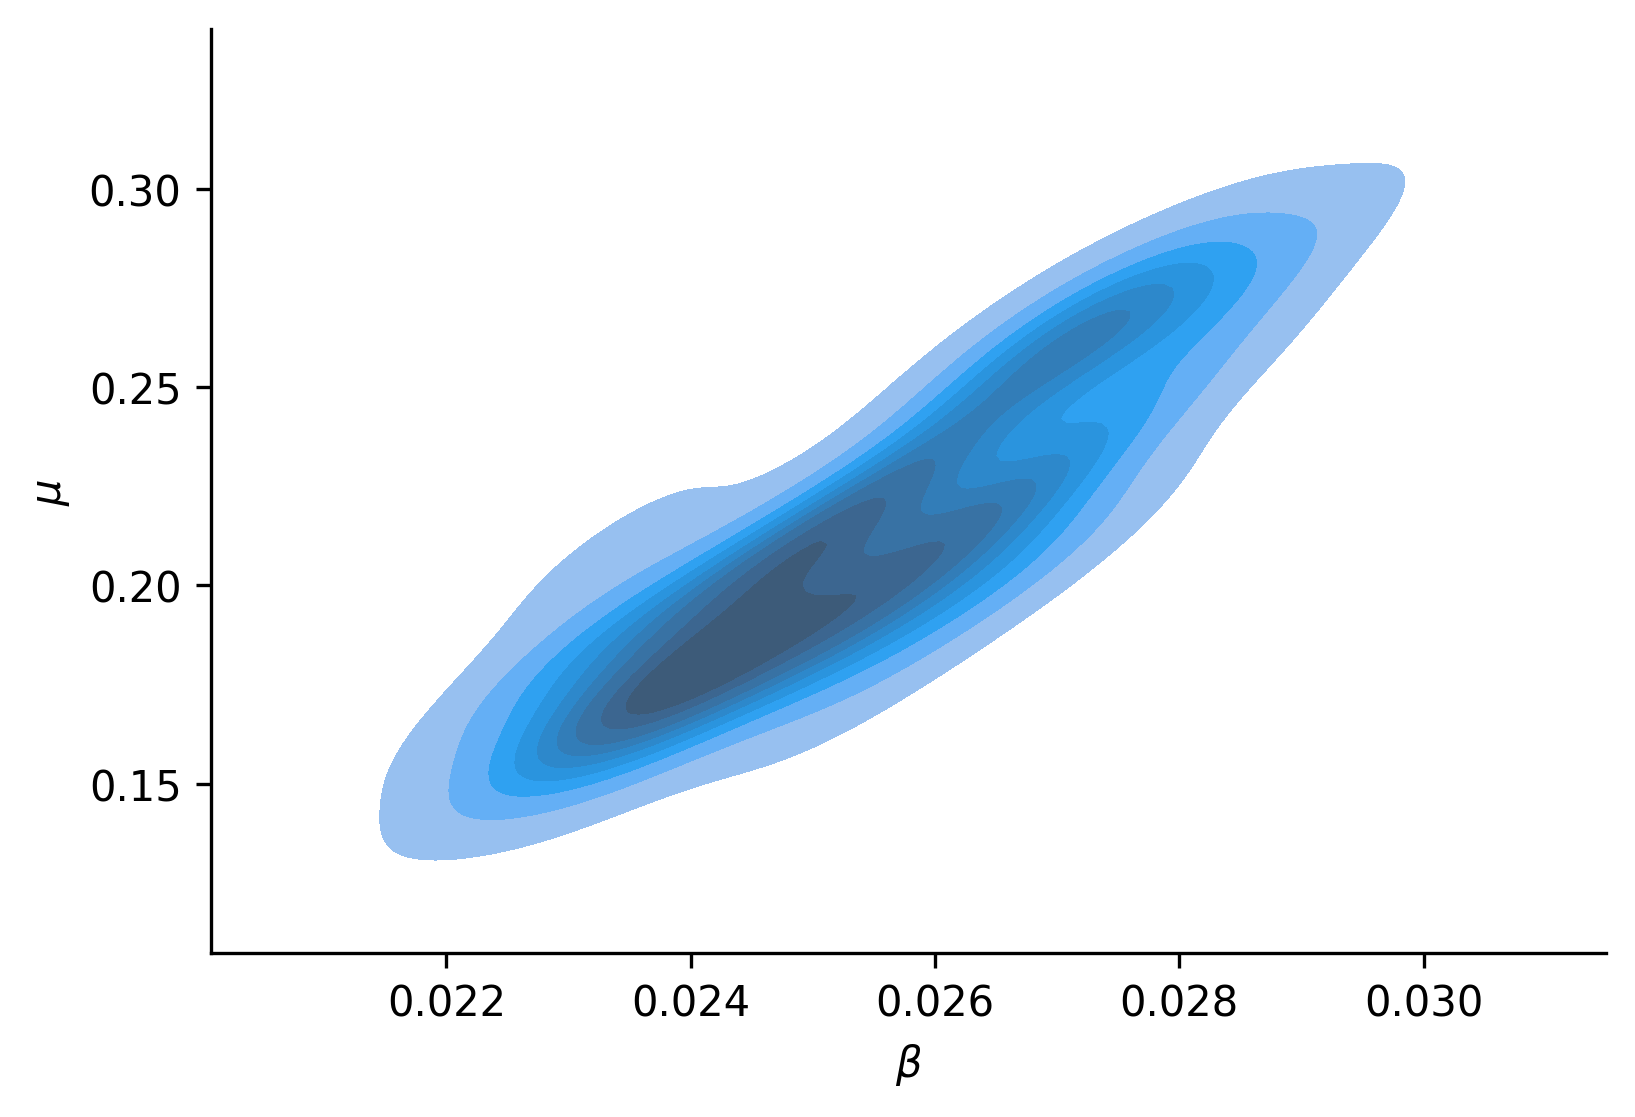

In [11]:
plot_posterior_2d(results, "beta", "mu", kind="kde", prior_range=False, xlabel="$\\beta$", ylabel="$\\mu$")

### Incidence Example

In [12]:
def post_processing_function(results, **parameters): 
    results.update({"data": np.concatenate(([0], (np.abs(np.diff(results["S_total"])))))})
    return results

results = calibration_top_perc(simulation_function=stochastic_simulation, 
                               parameters=parameters,
                               priors=priors, 
                               data={"data": df_incidence["incidence"].values},
                               top_perc=0.05,
                               Nsim=1000,
                               post_processing_function=post_processing_function)

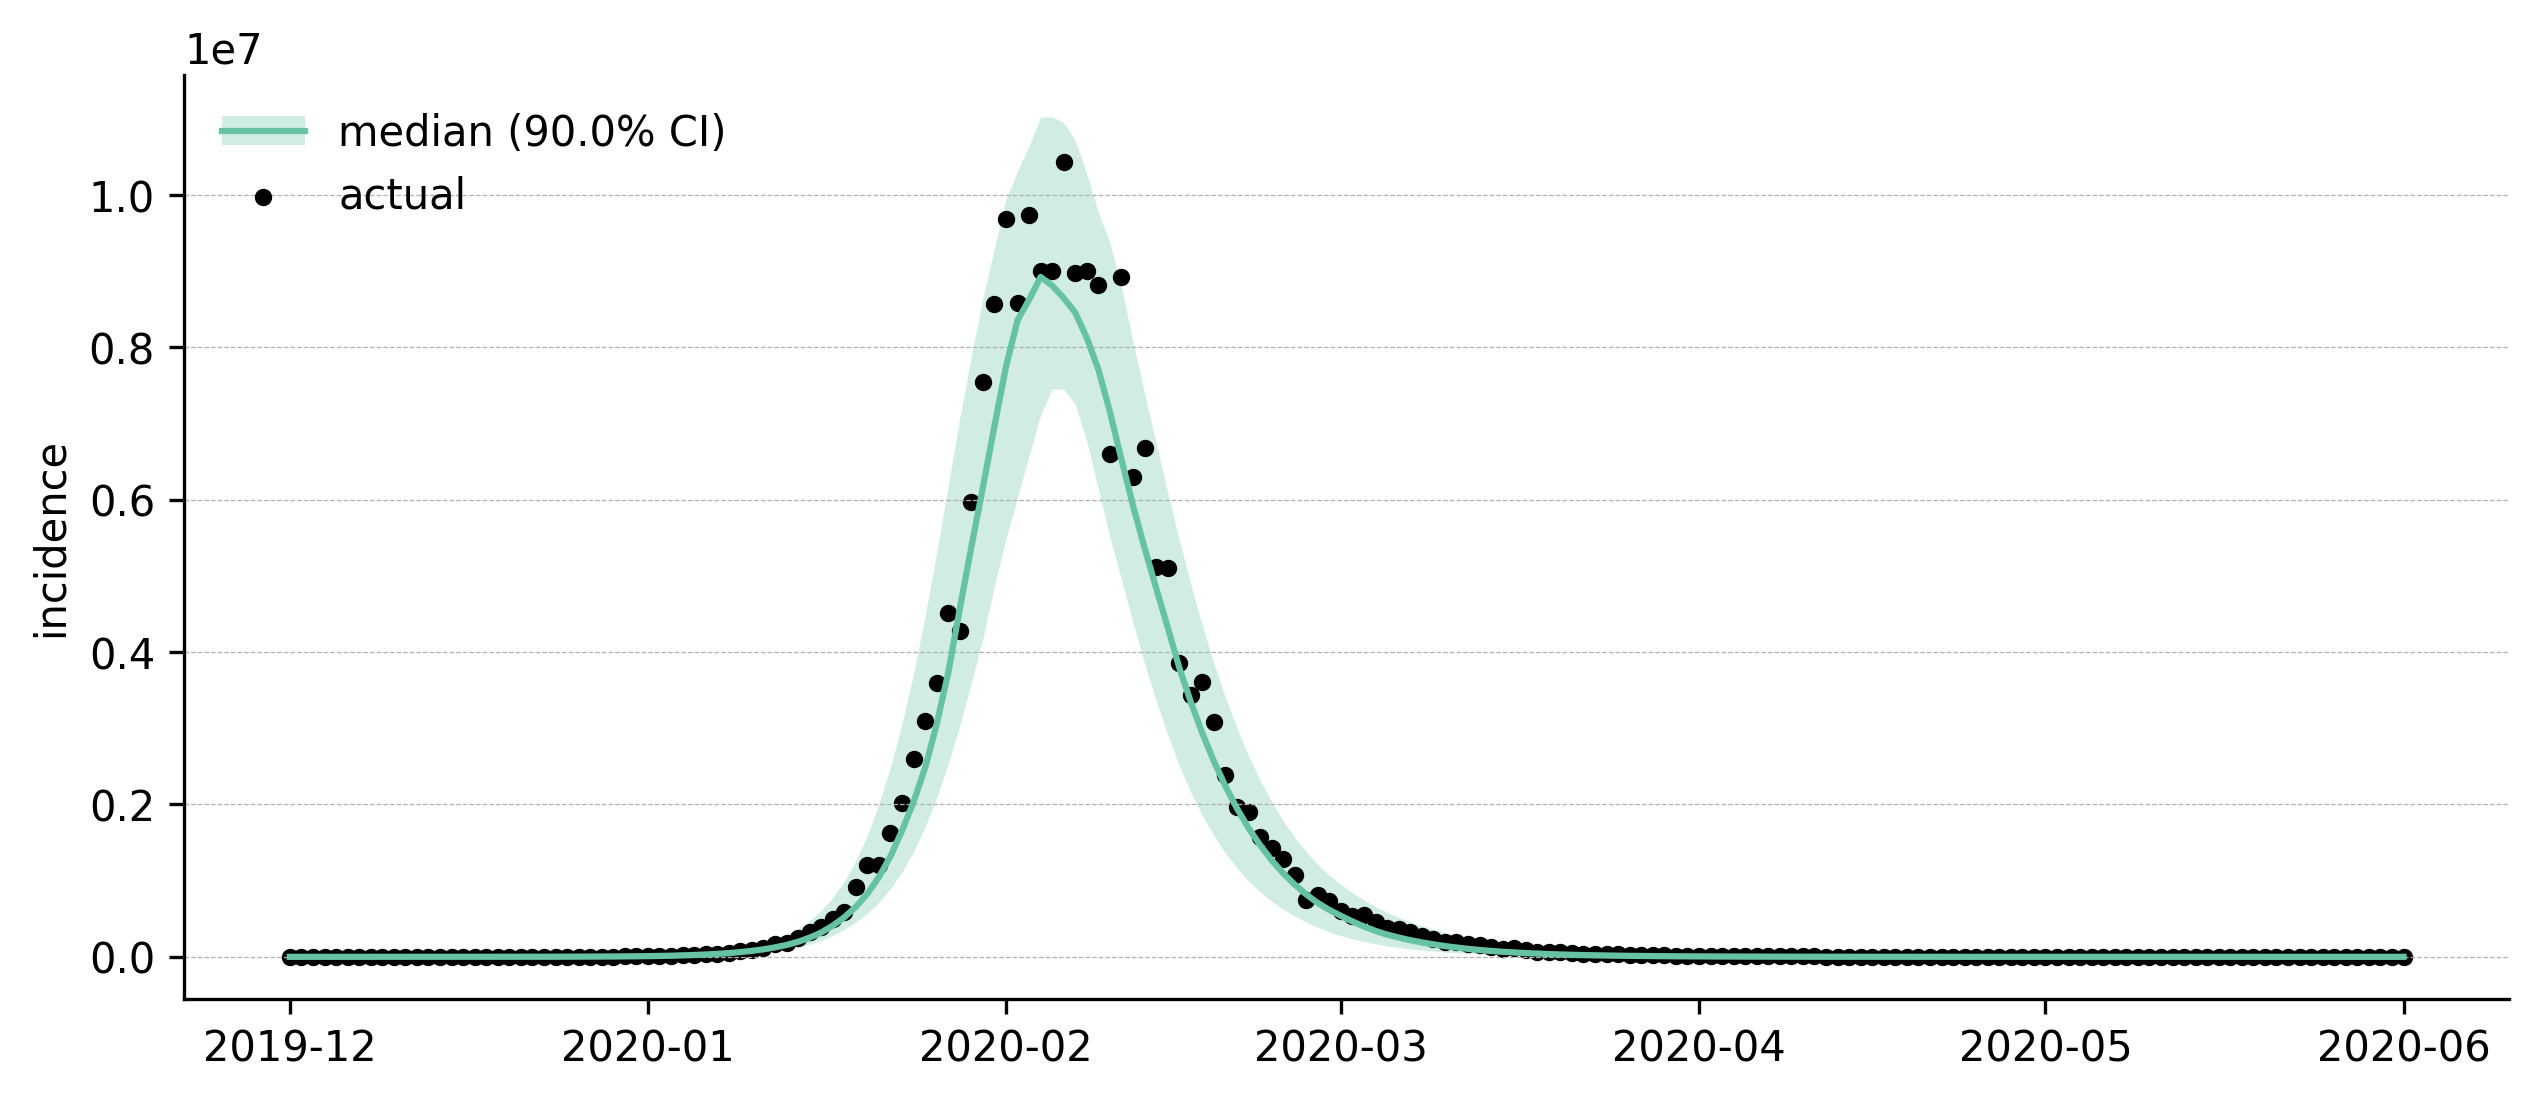

In [13]:
plot_selected_quantiles(results, ylabel="incidence")

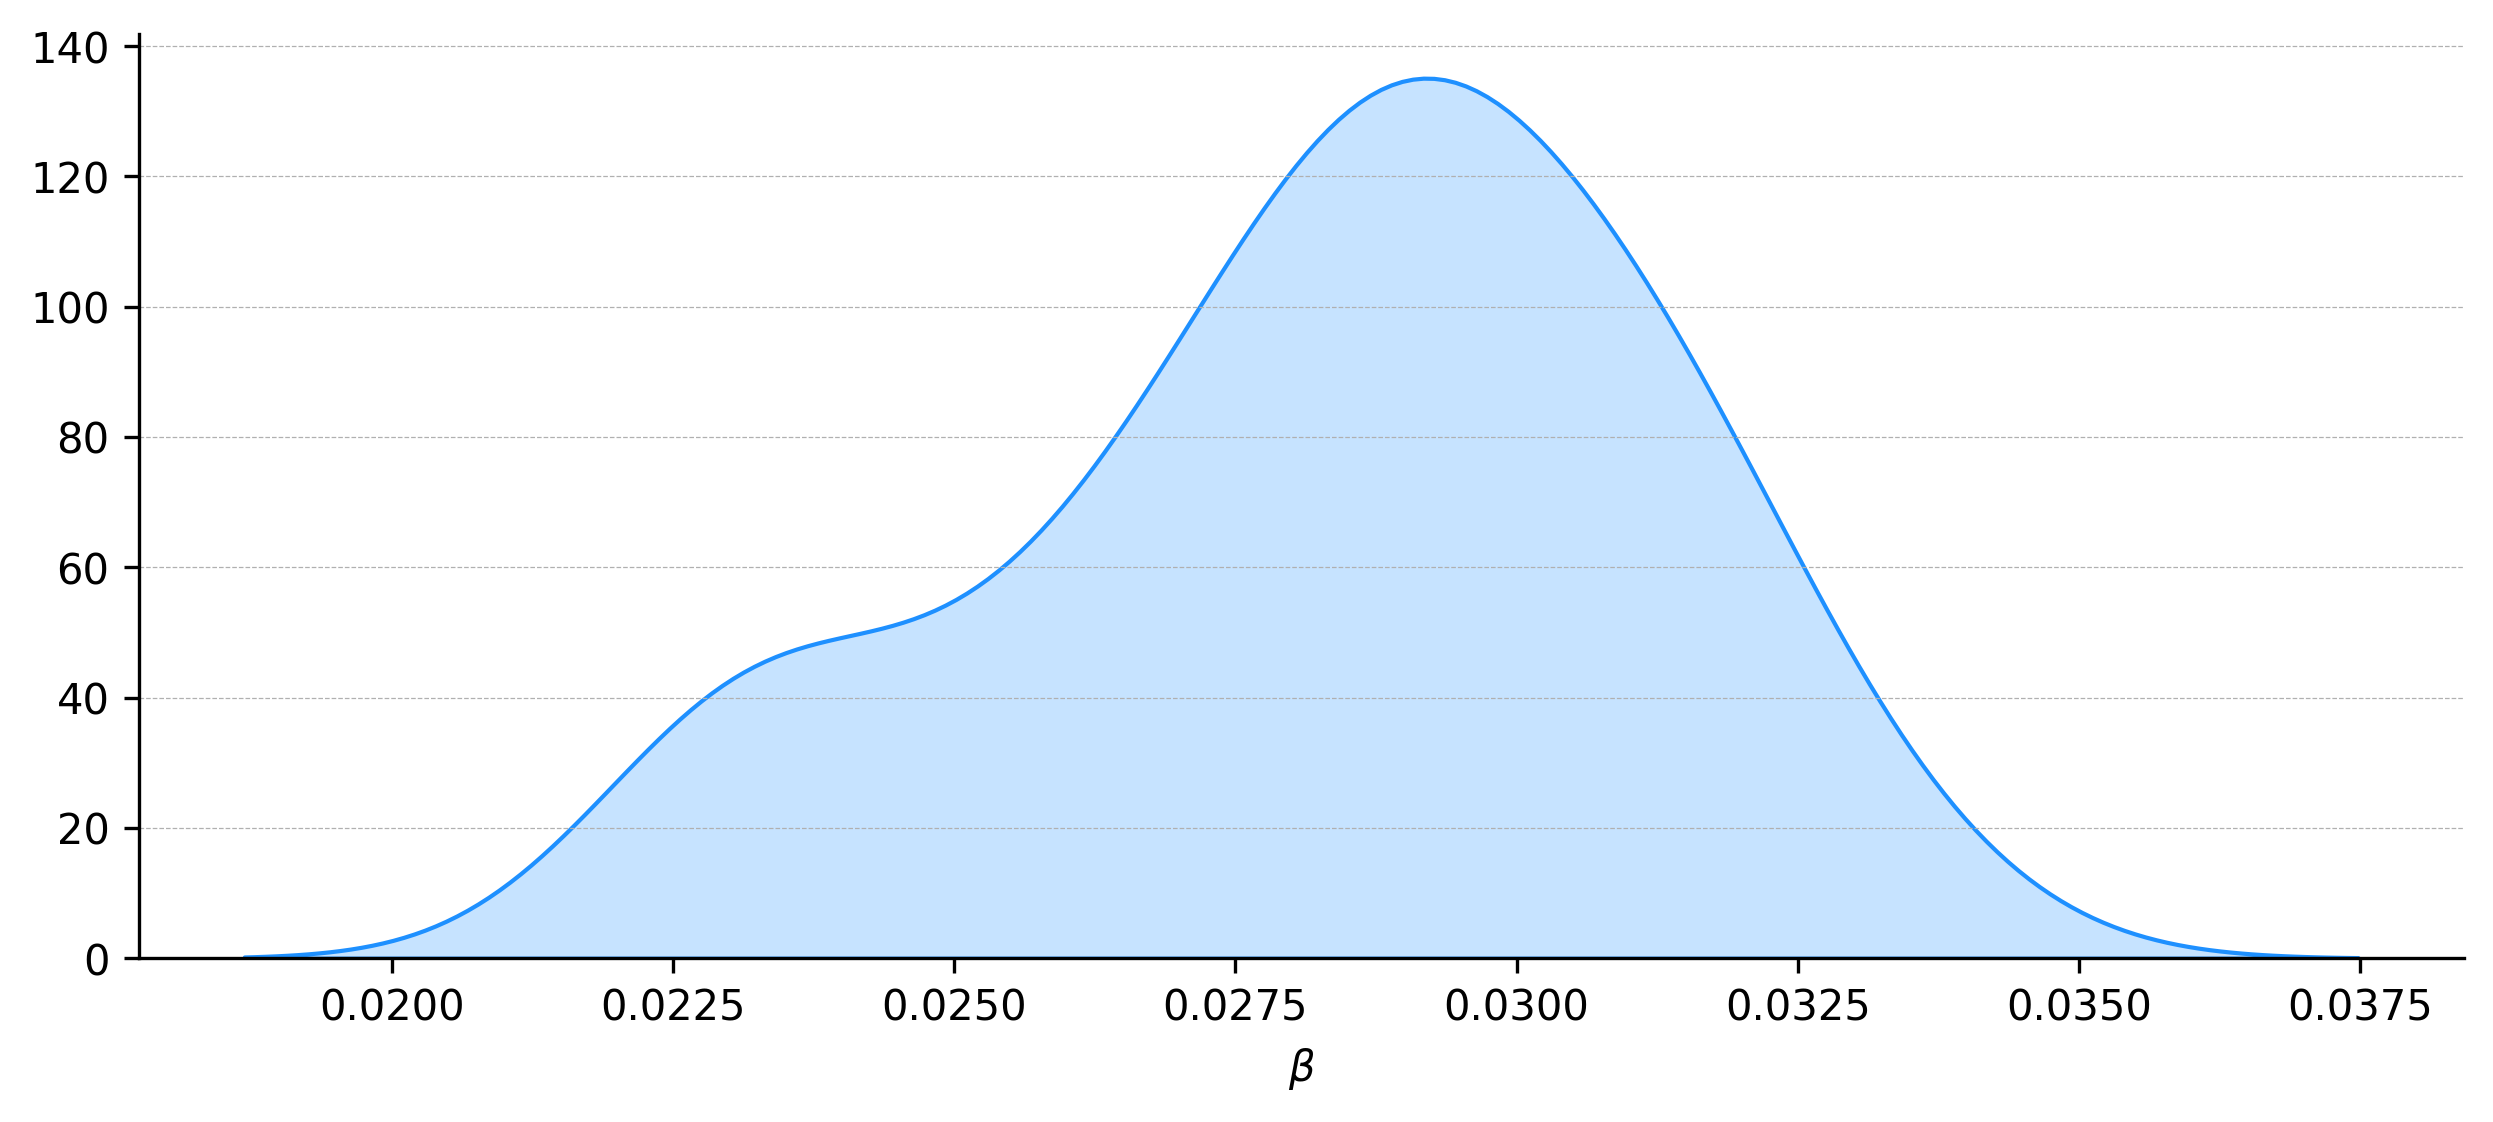

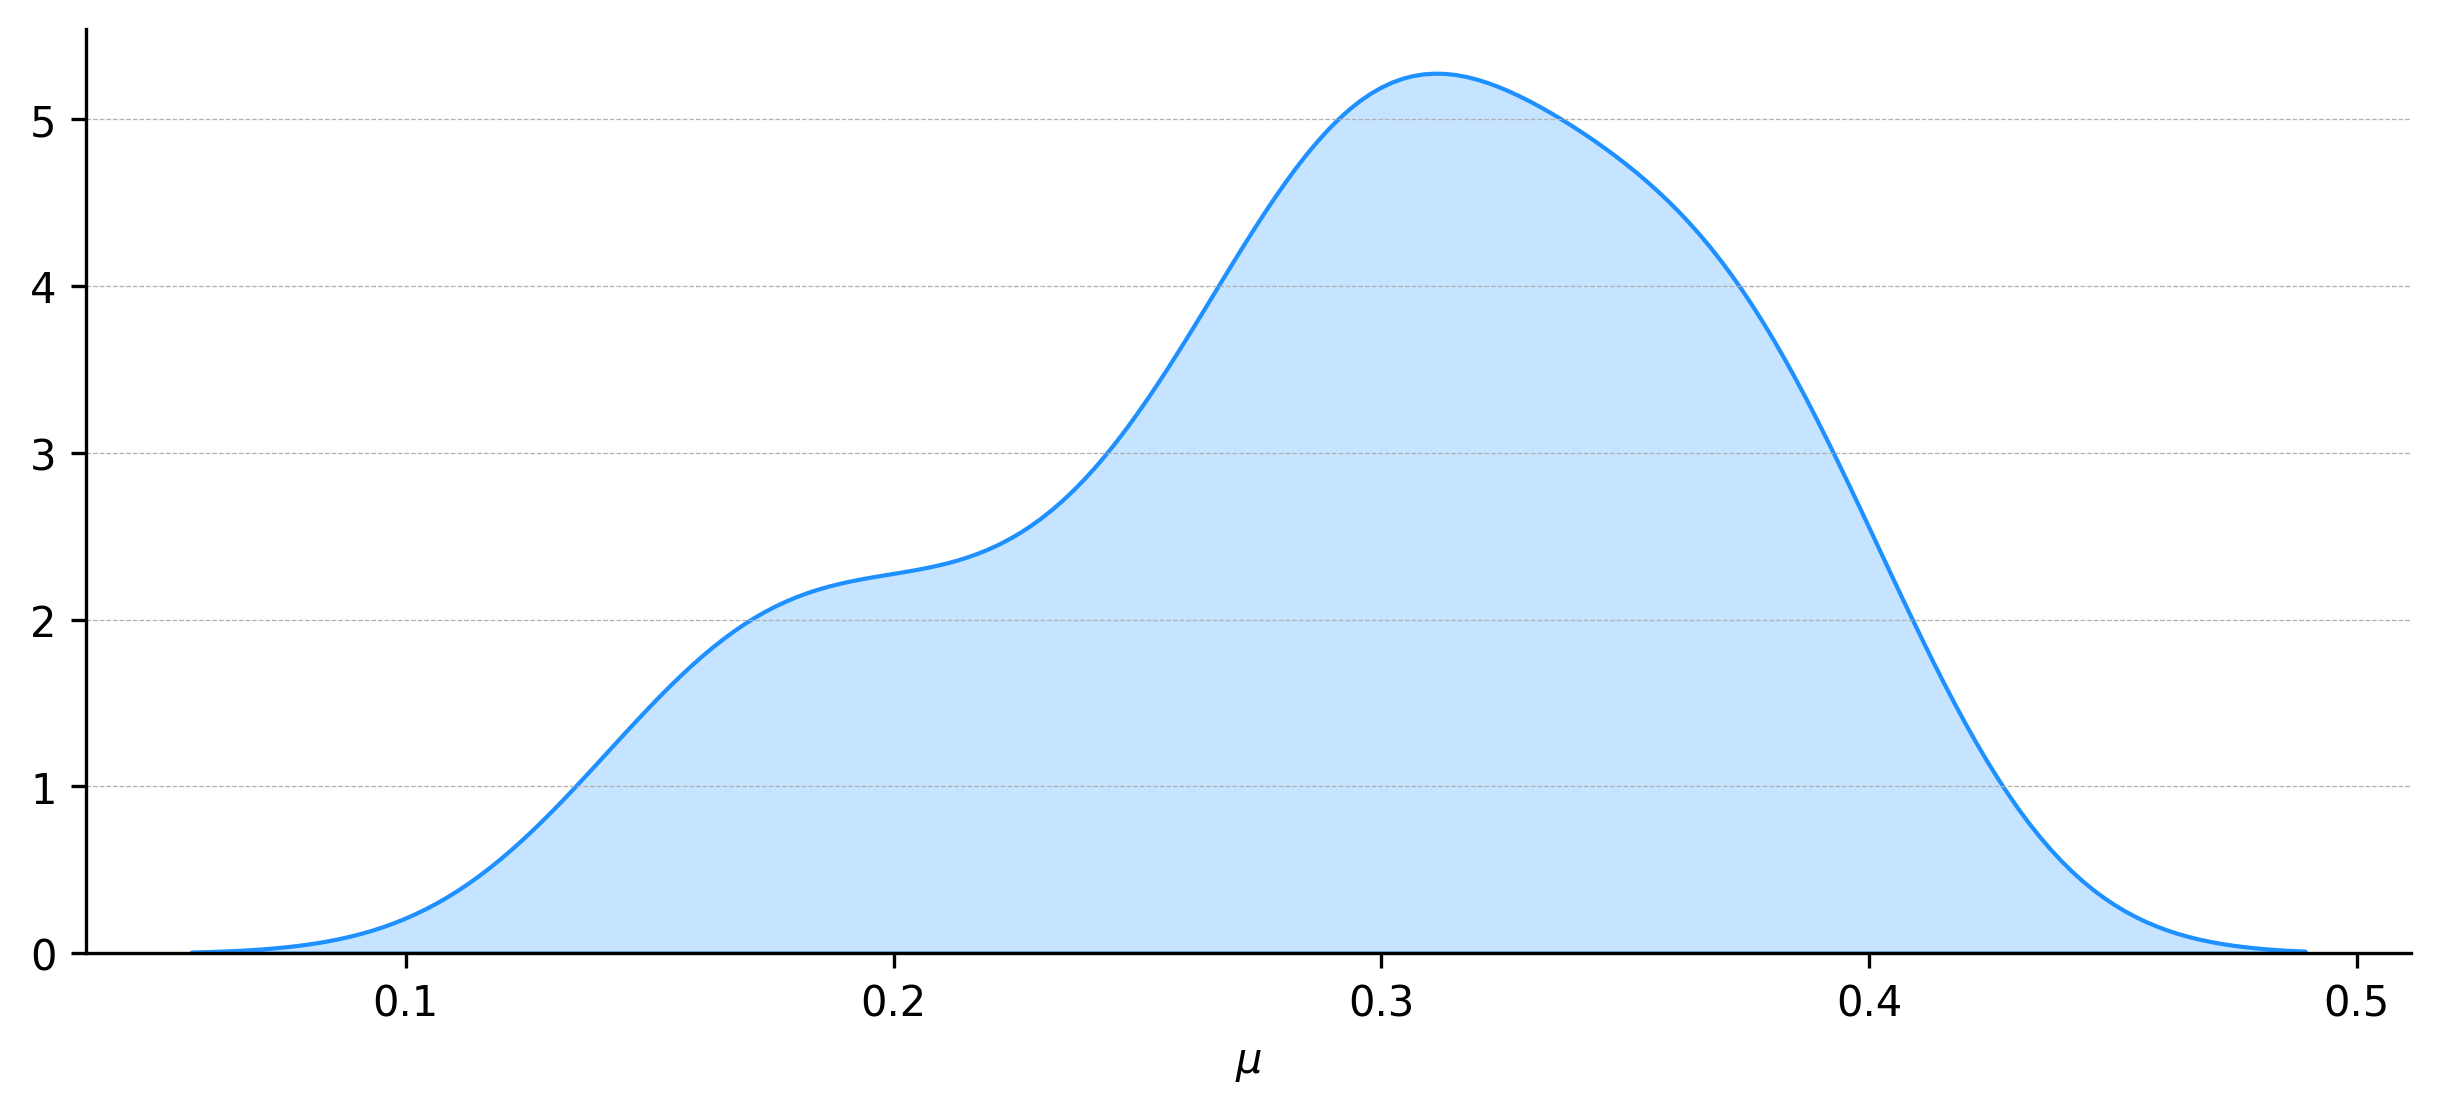

In [14]:
plot_posterior(results, "beta", kind="kde", prior_range=False, xlabel="$\\beta$")
plot_posterior(results, "mu", kind="kde", prior_range=False, xlabel="$\\mu$")

../epydemix/plotting.py:229: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_posterior, x=parameter_x, y=parameter_y, ax=ax, fill=True, palette=palette, **kwargs)


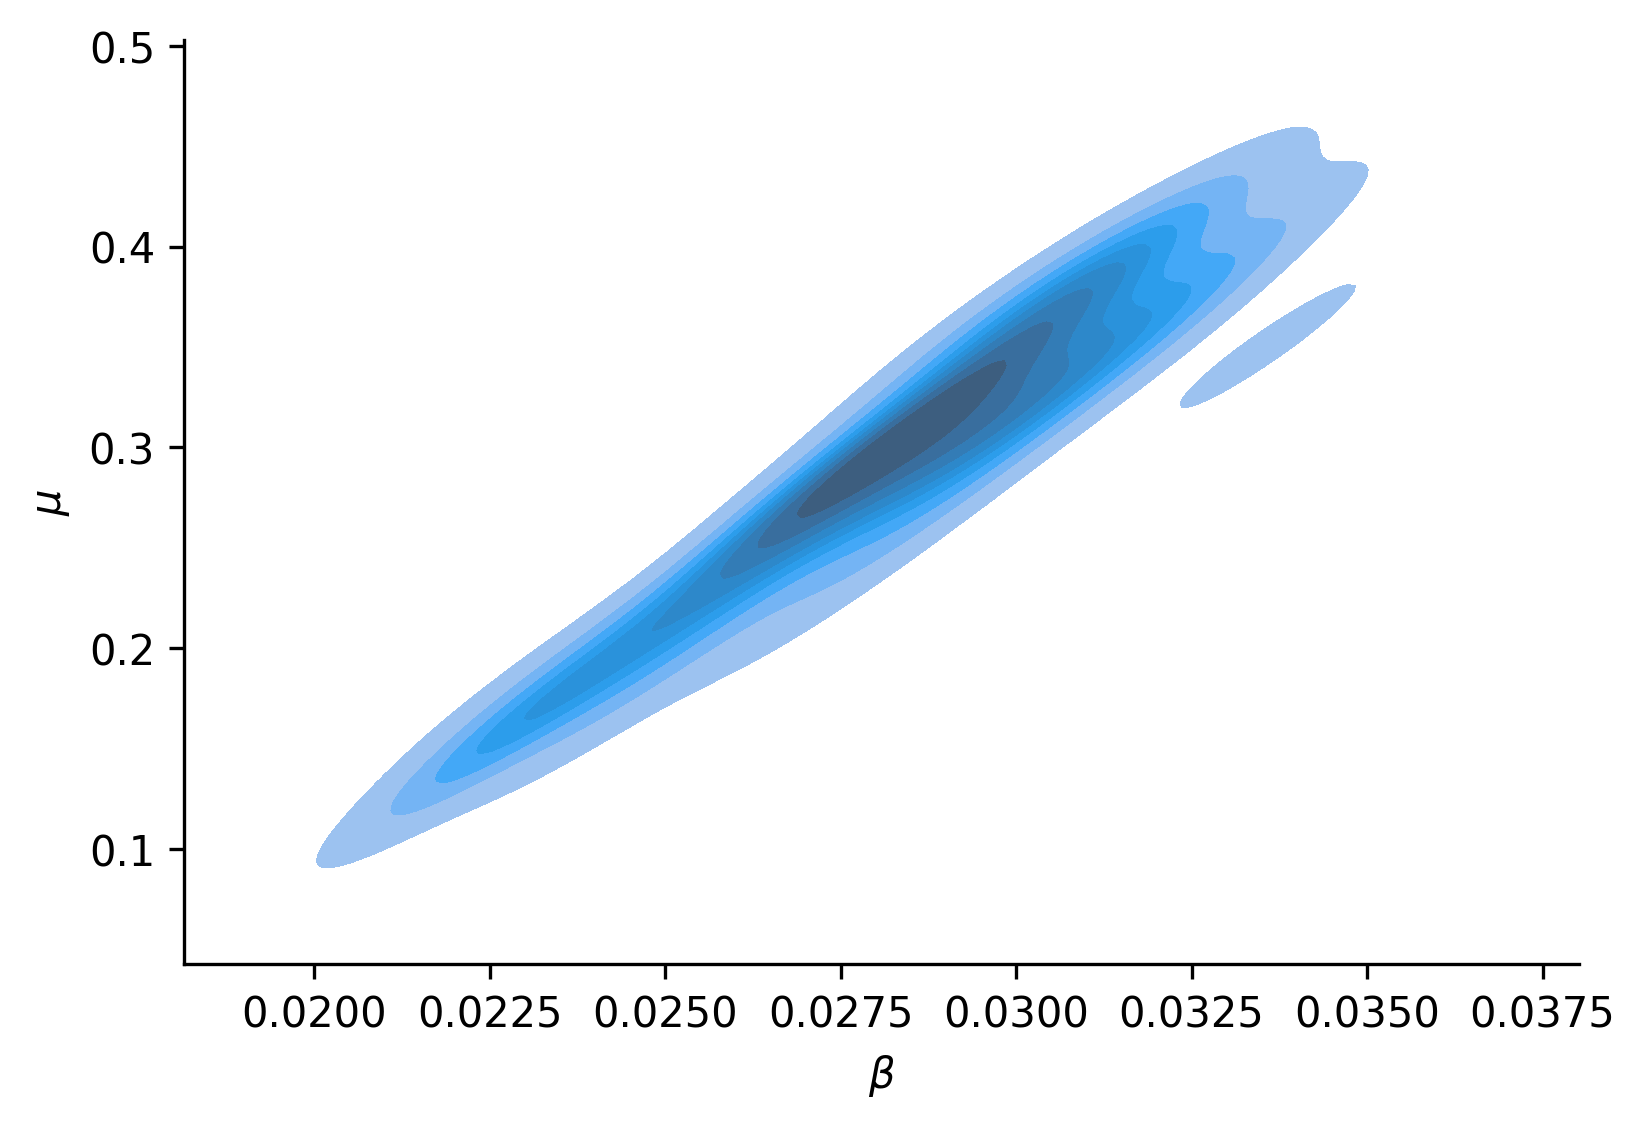

In [15]:
plot_posterior_2d(results, "beta", "mu", kind="kde", prior_range=False, xlabel="$\\beta$", ylabel="$\\mu$")

## ABC-SMC

In [16]:
def post_processing_function(results, **parameters): 
    results.update({"data": np.concatenate(([0], (np.abs(np.diff(results["S_total"])))))})
    return results

results = calibration_abc_smc(simulation_function=stochastic_simulation, 
                              priors=priors, 
                              parameters=parameters, 
                              data={"data": df_incidence["incidence"].values}, 
                              post_processing_function=post_processing_function, 
                              population_size=50)

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2024-07-10 14:46:05>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 2.96353063e+06.
ABC INFO: Accepted: 50 / 94 = 5.3191e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 2.54823267e+06.
ABC INFO: Accepted: 50 / 147 = 3.4014e-01, ESS: 4.7708e+01.
ABC INFO: t: 2, eps: 1.50221491e+06.
ABC INFO: Accepted: 50 / 106 = 4.7170e-01, ESS: 4.6390e+01.
ABC INFO: t: 3, eps: 8.23264235e+05.
ABC INFO: Accepted: 50 / 120 = 4.1667e-01, ESS: 4.7458e+01.
ABC INFO: t: 4, eps: 5.62784409e+05.
ABC INFO: Accepted: 50 / 127 = 3.9370e-01, ESS: 4.4889e+01.
ABC INFO: t: 5, eps: 4.03319456e+05.
ABC INFO: Accepted: 50 / 267 = 1.8727e-01, ESS: 3.9846e+01.
ABC INFO: t: 6, eps: 3.51771432e+05.
ABC INFO: Accepted: 50 / 269 = 1.8587e-01, ESS: 3.9371e+01.
ABC INFO: t: 7, eps: 3.13674298e+05.
ABC INFO: Accepted: 50 / 374 = 1.3369e-01, ESS: 3.8725e+01.
ABC INFO: t: 8, eps: 2.89075977e+05.
ABC INFO: Accepted: 50 / 5

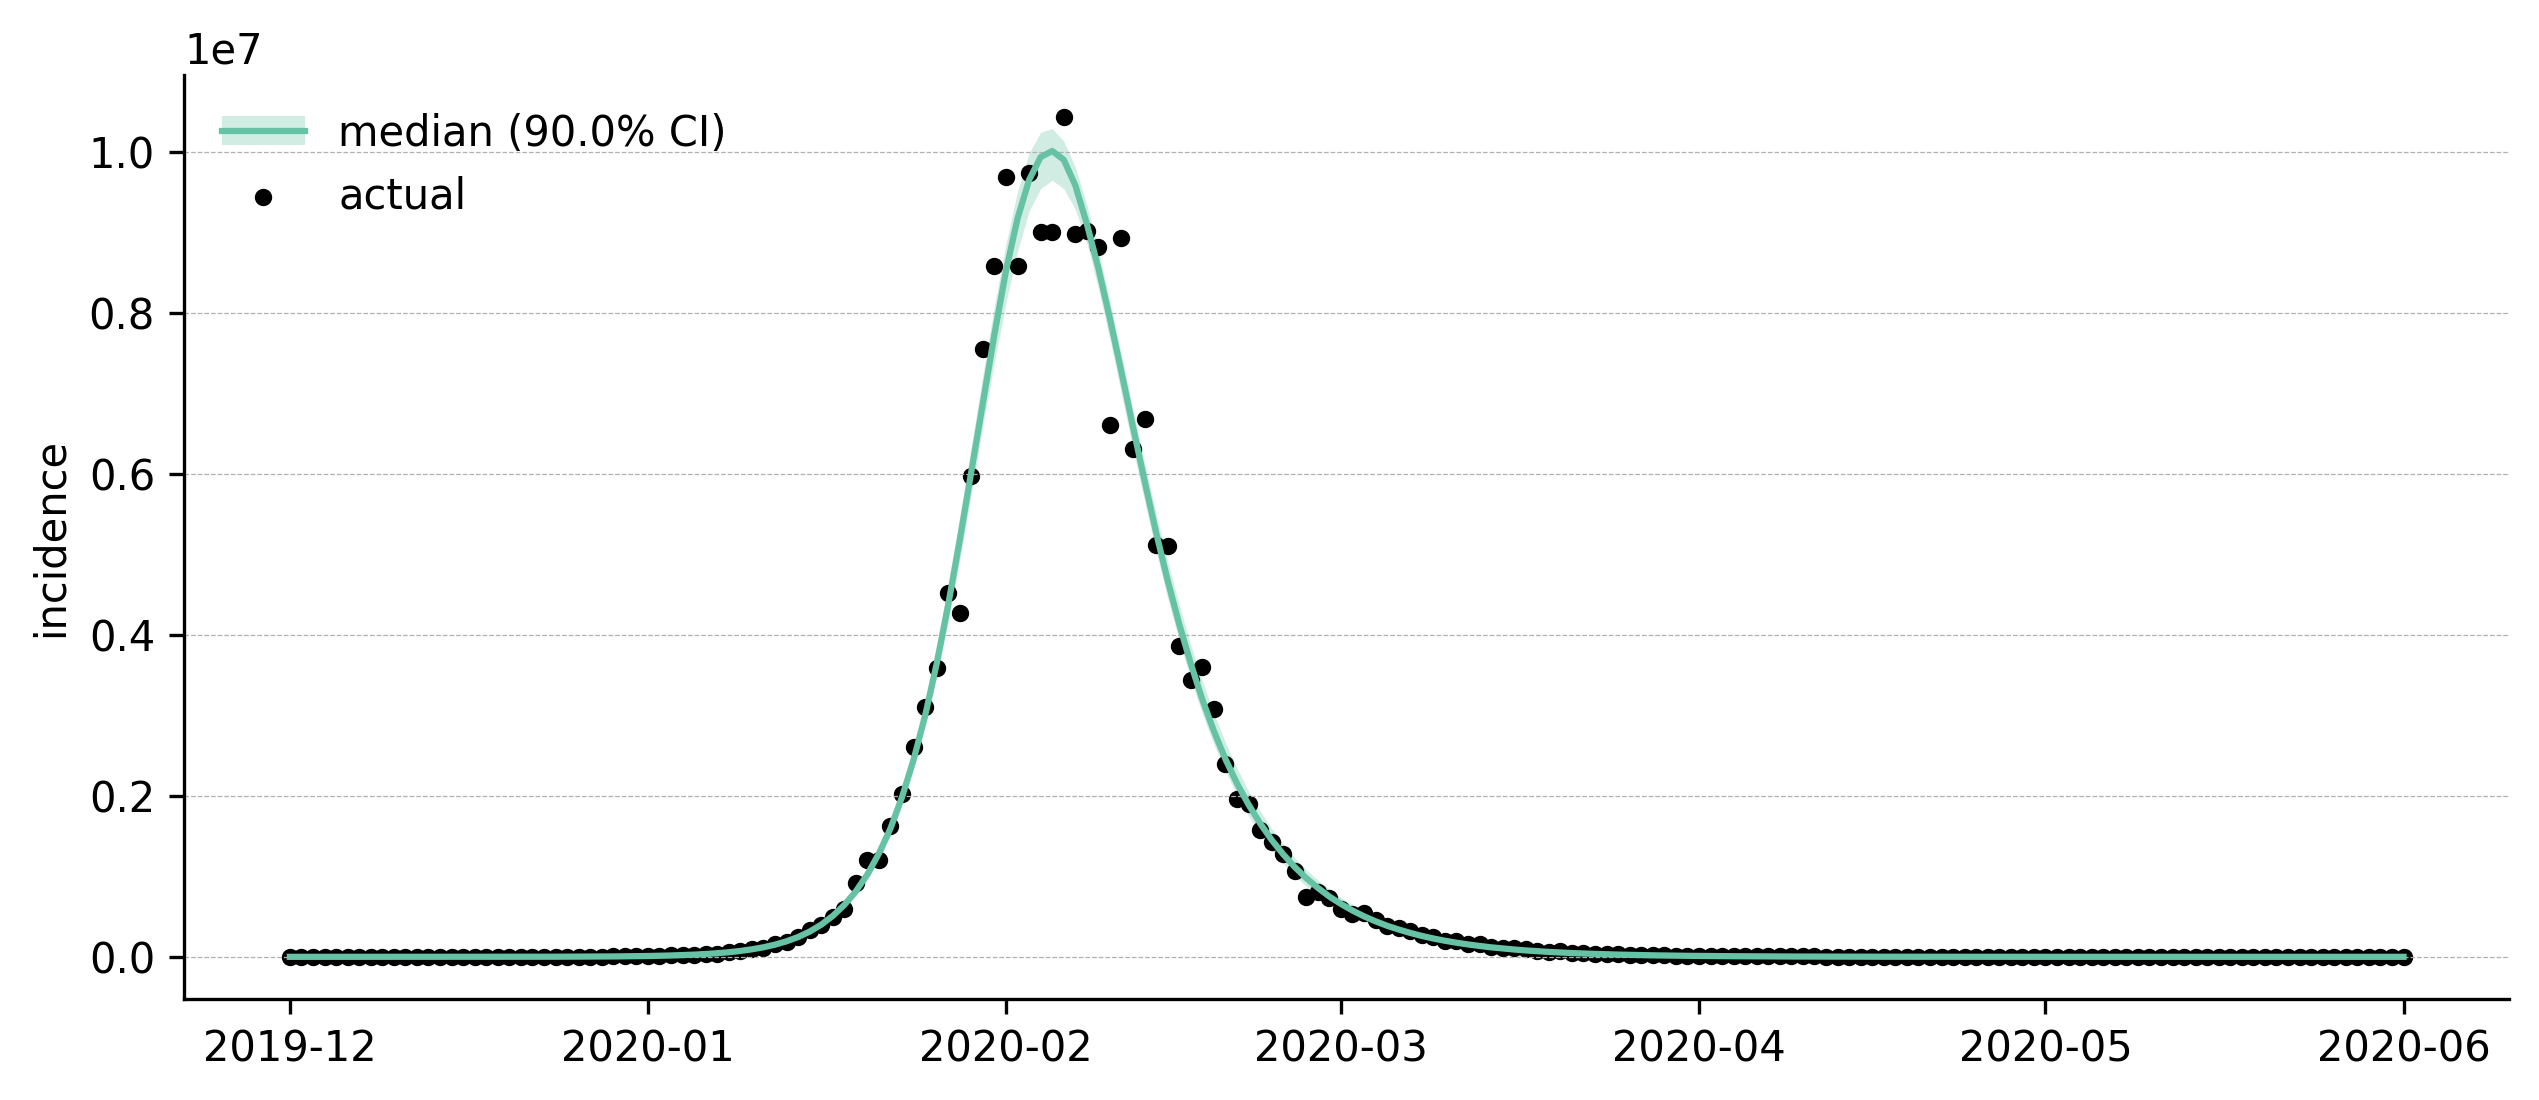

In [17]:
plot_selected_quantiles(results, ylabel="incidence")

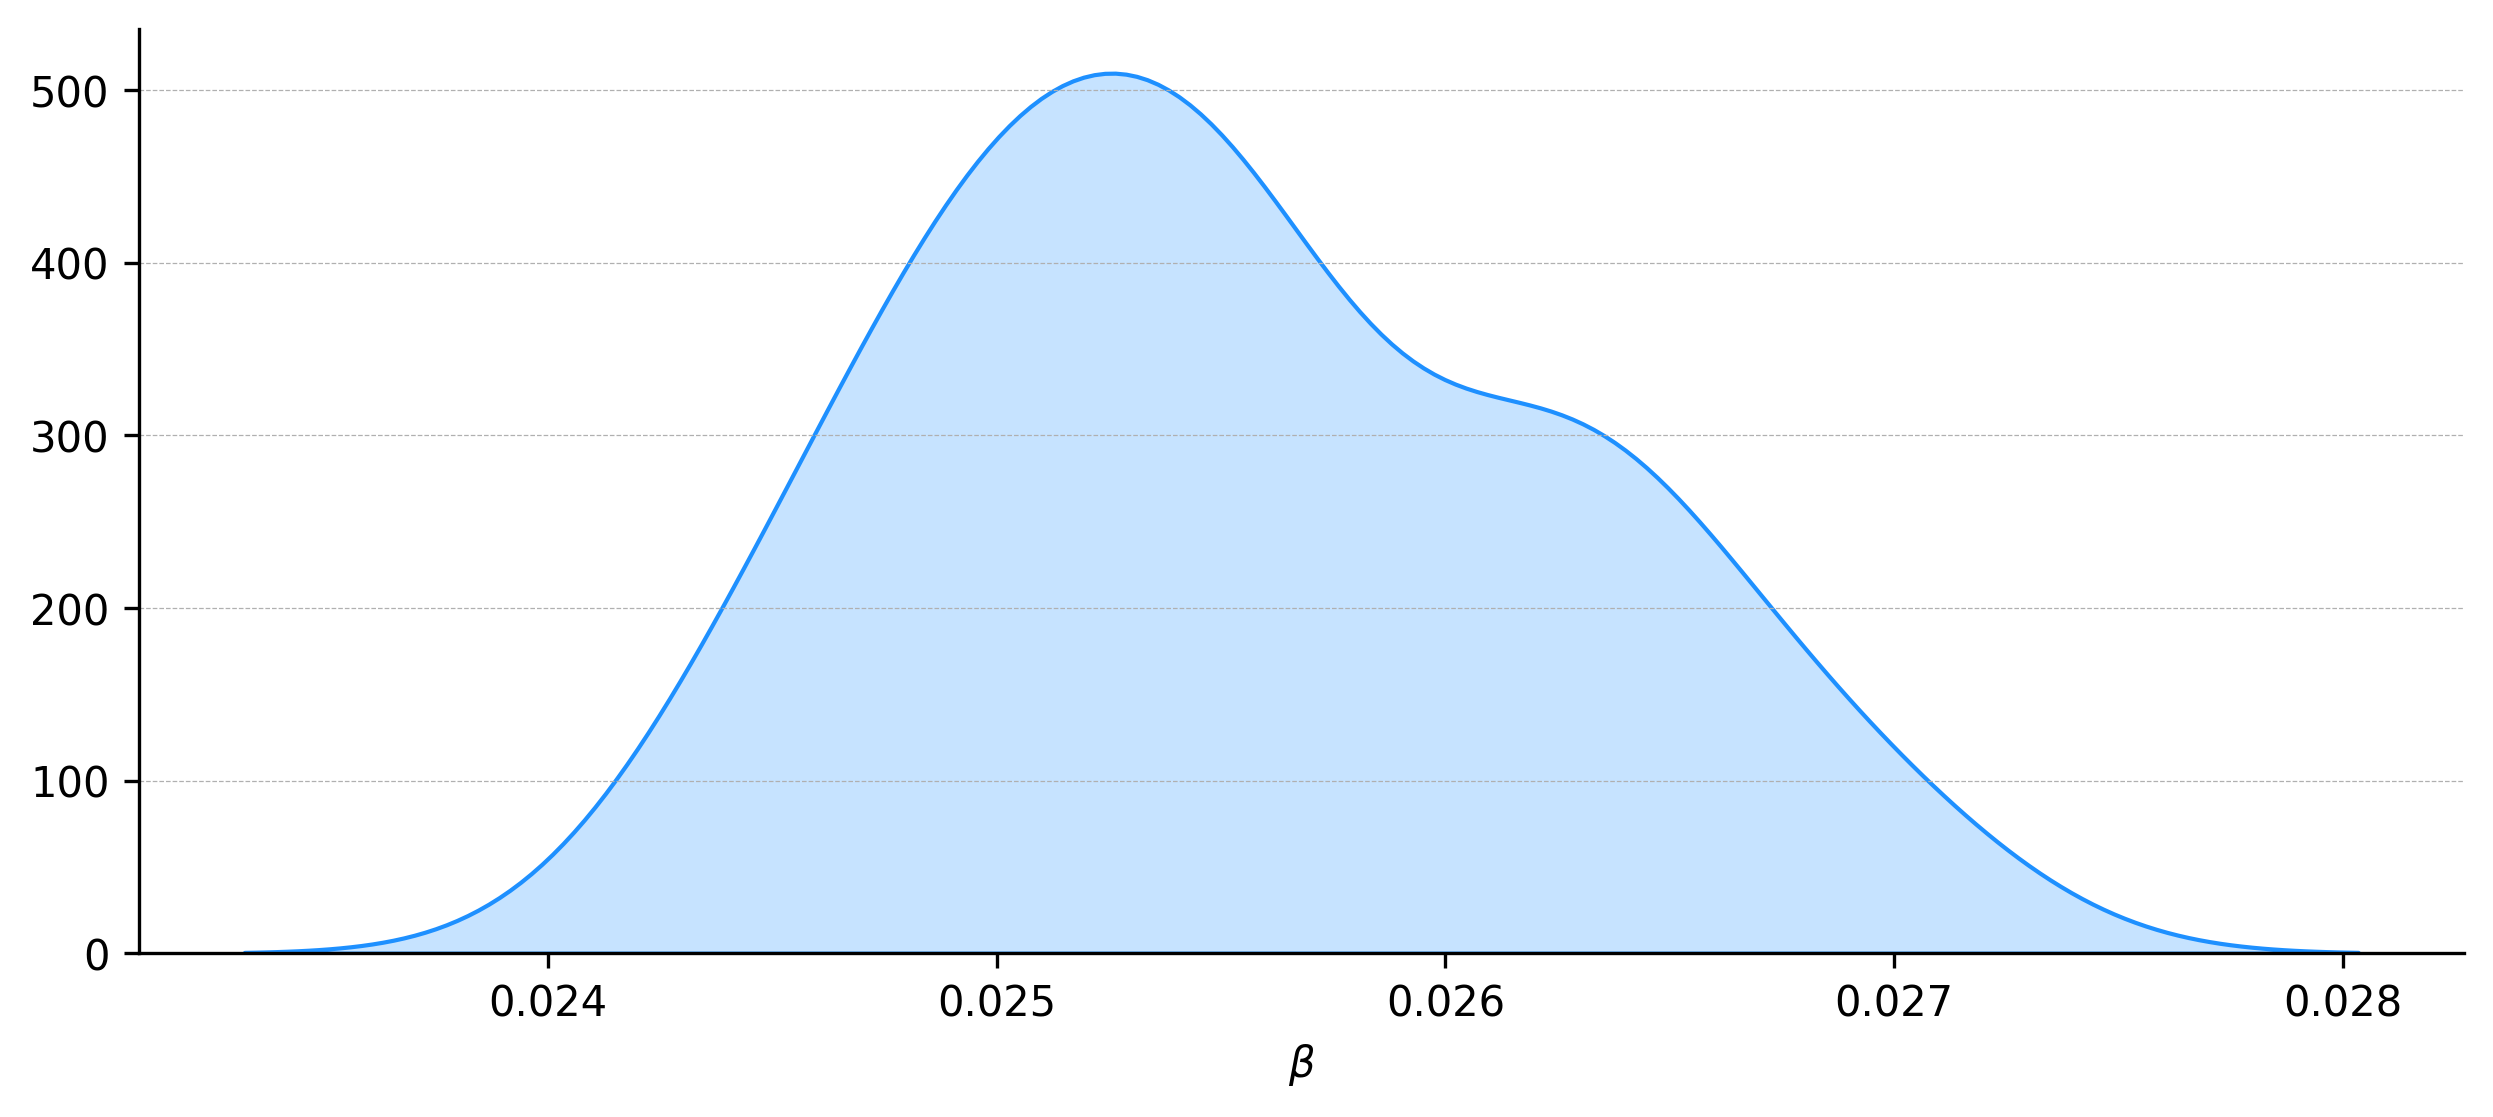

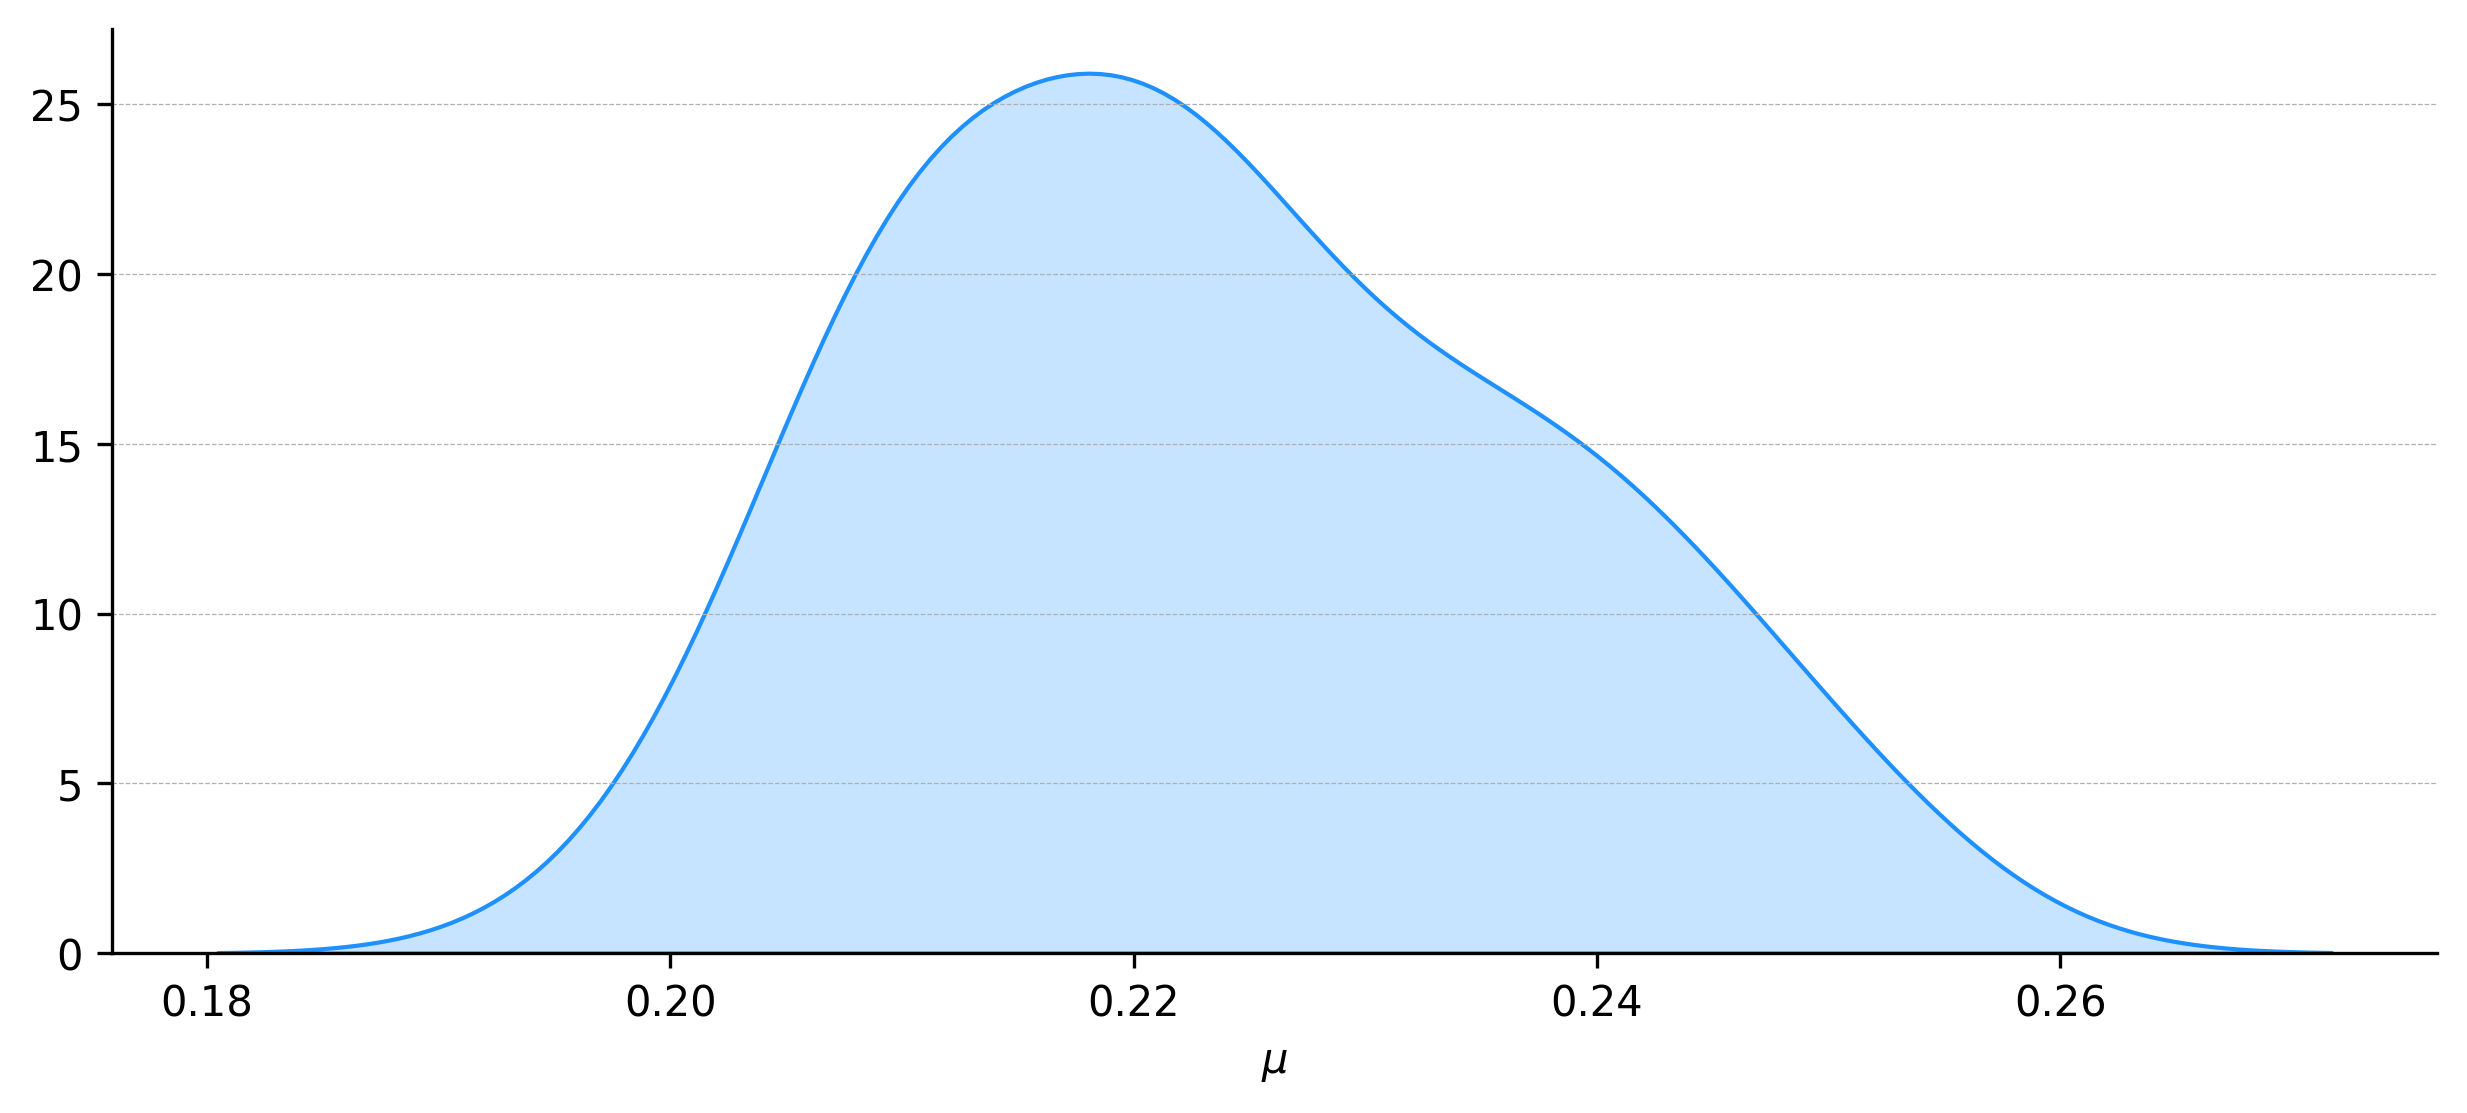

In [18]:
plot_posterior(results, "beta", kind="kde", prior_range=False, xlabel="$\\beta$")
plot_posterior(results, "mu", kind="kde", prior_range=False, xlabel="$\\mu$")

../epydemix/plotting.py:229: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_posterior, x=parameter_x, y=parameter_y, ax=ax, fill=True, palette=palette, **kwargs)


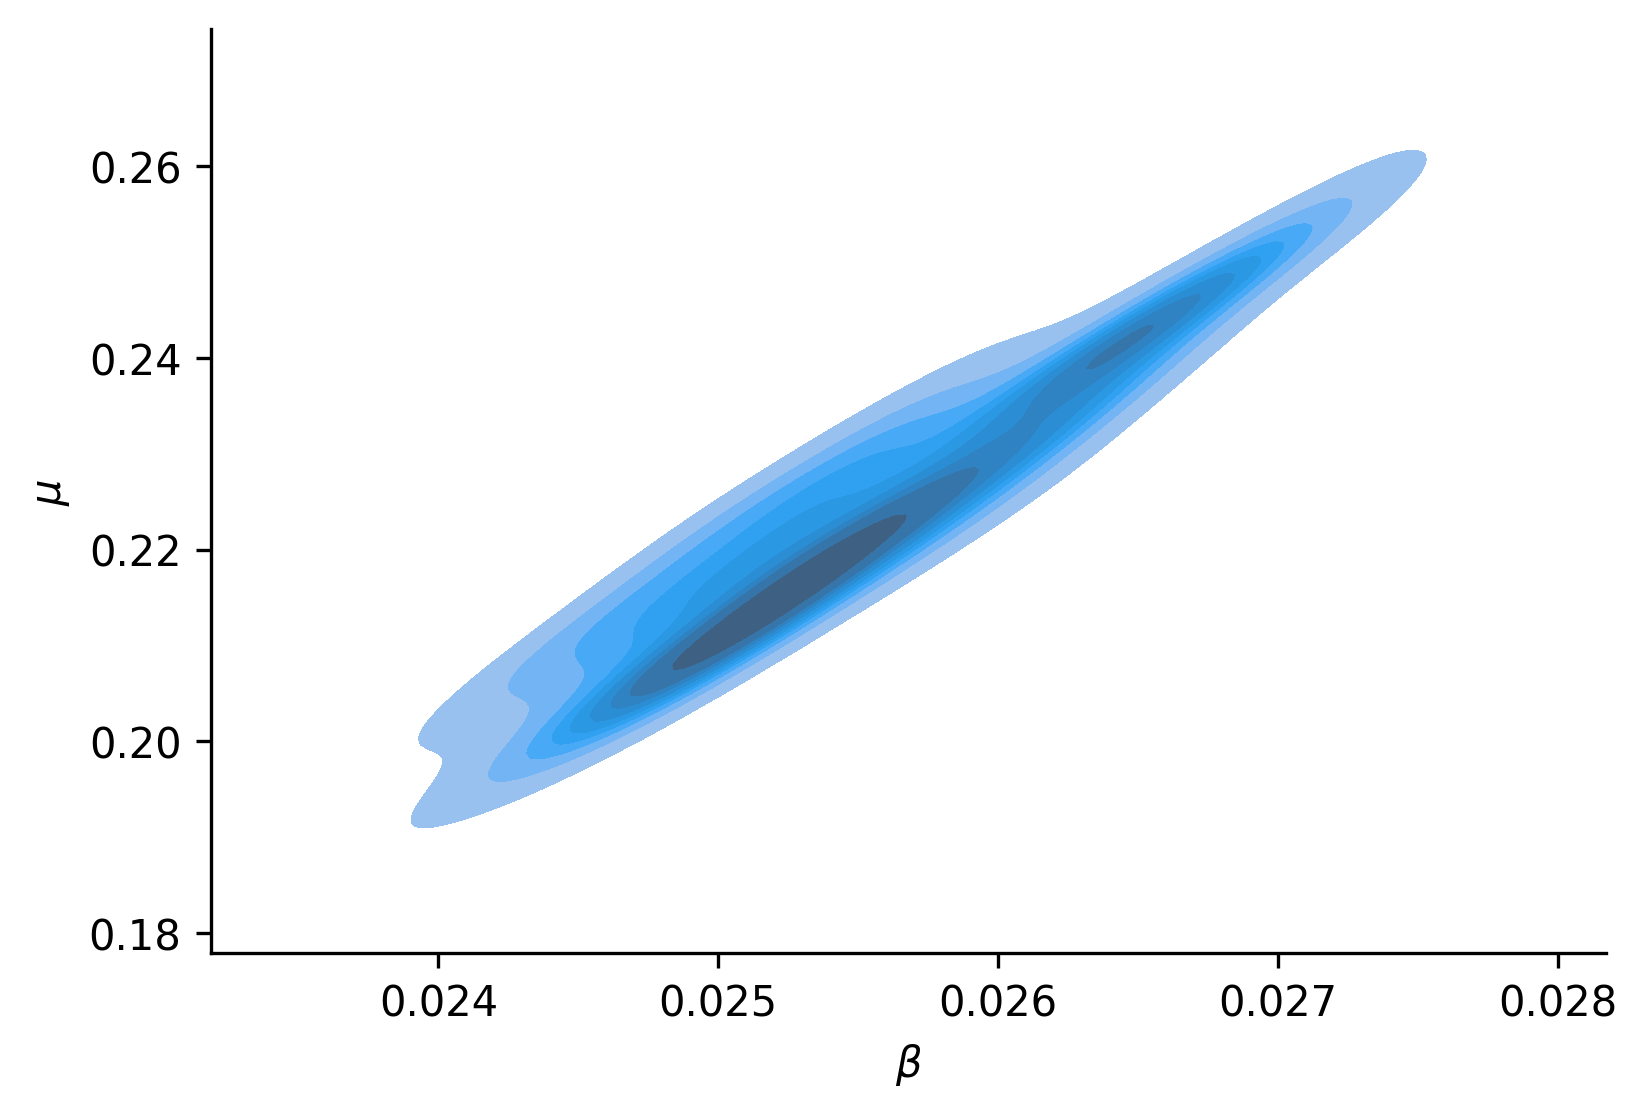

In [19]:
plot_posterior_2d(results, "beta", "mu", kind="kde", prior_range=False, xlabel="$\\beta$", ylabel="$\\mu$")

# Calibrating your own model

In [7]:
from models.custom_models import my_stochastic_SIR

parameters = {
    'S': 273523000 - 10,
    'I': 10,
    'R': 0,
    'N': 273523000,
    'simulation_dates': simulation_dates,
    'dt': 1.0}

# priors
priors = {"beta": stats.uniform(0.15, 0.35), "mu": stats.uniform(0.15, 0.15)}

In [11]:
results = calibration_top_perc(simulation_function=my_stochastic_SIR, 
                               parameters=parameters,
                               priors=priors, 
                               data={"data": df_incidence["incidence"].values},
                               top_perc=0.05,
                               Nsim=10000)

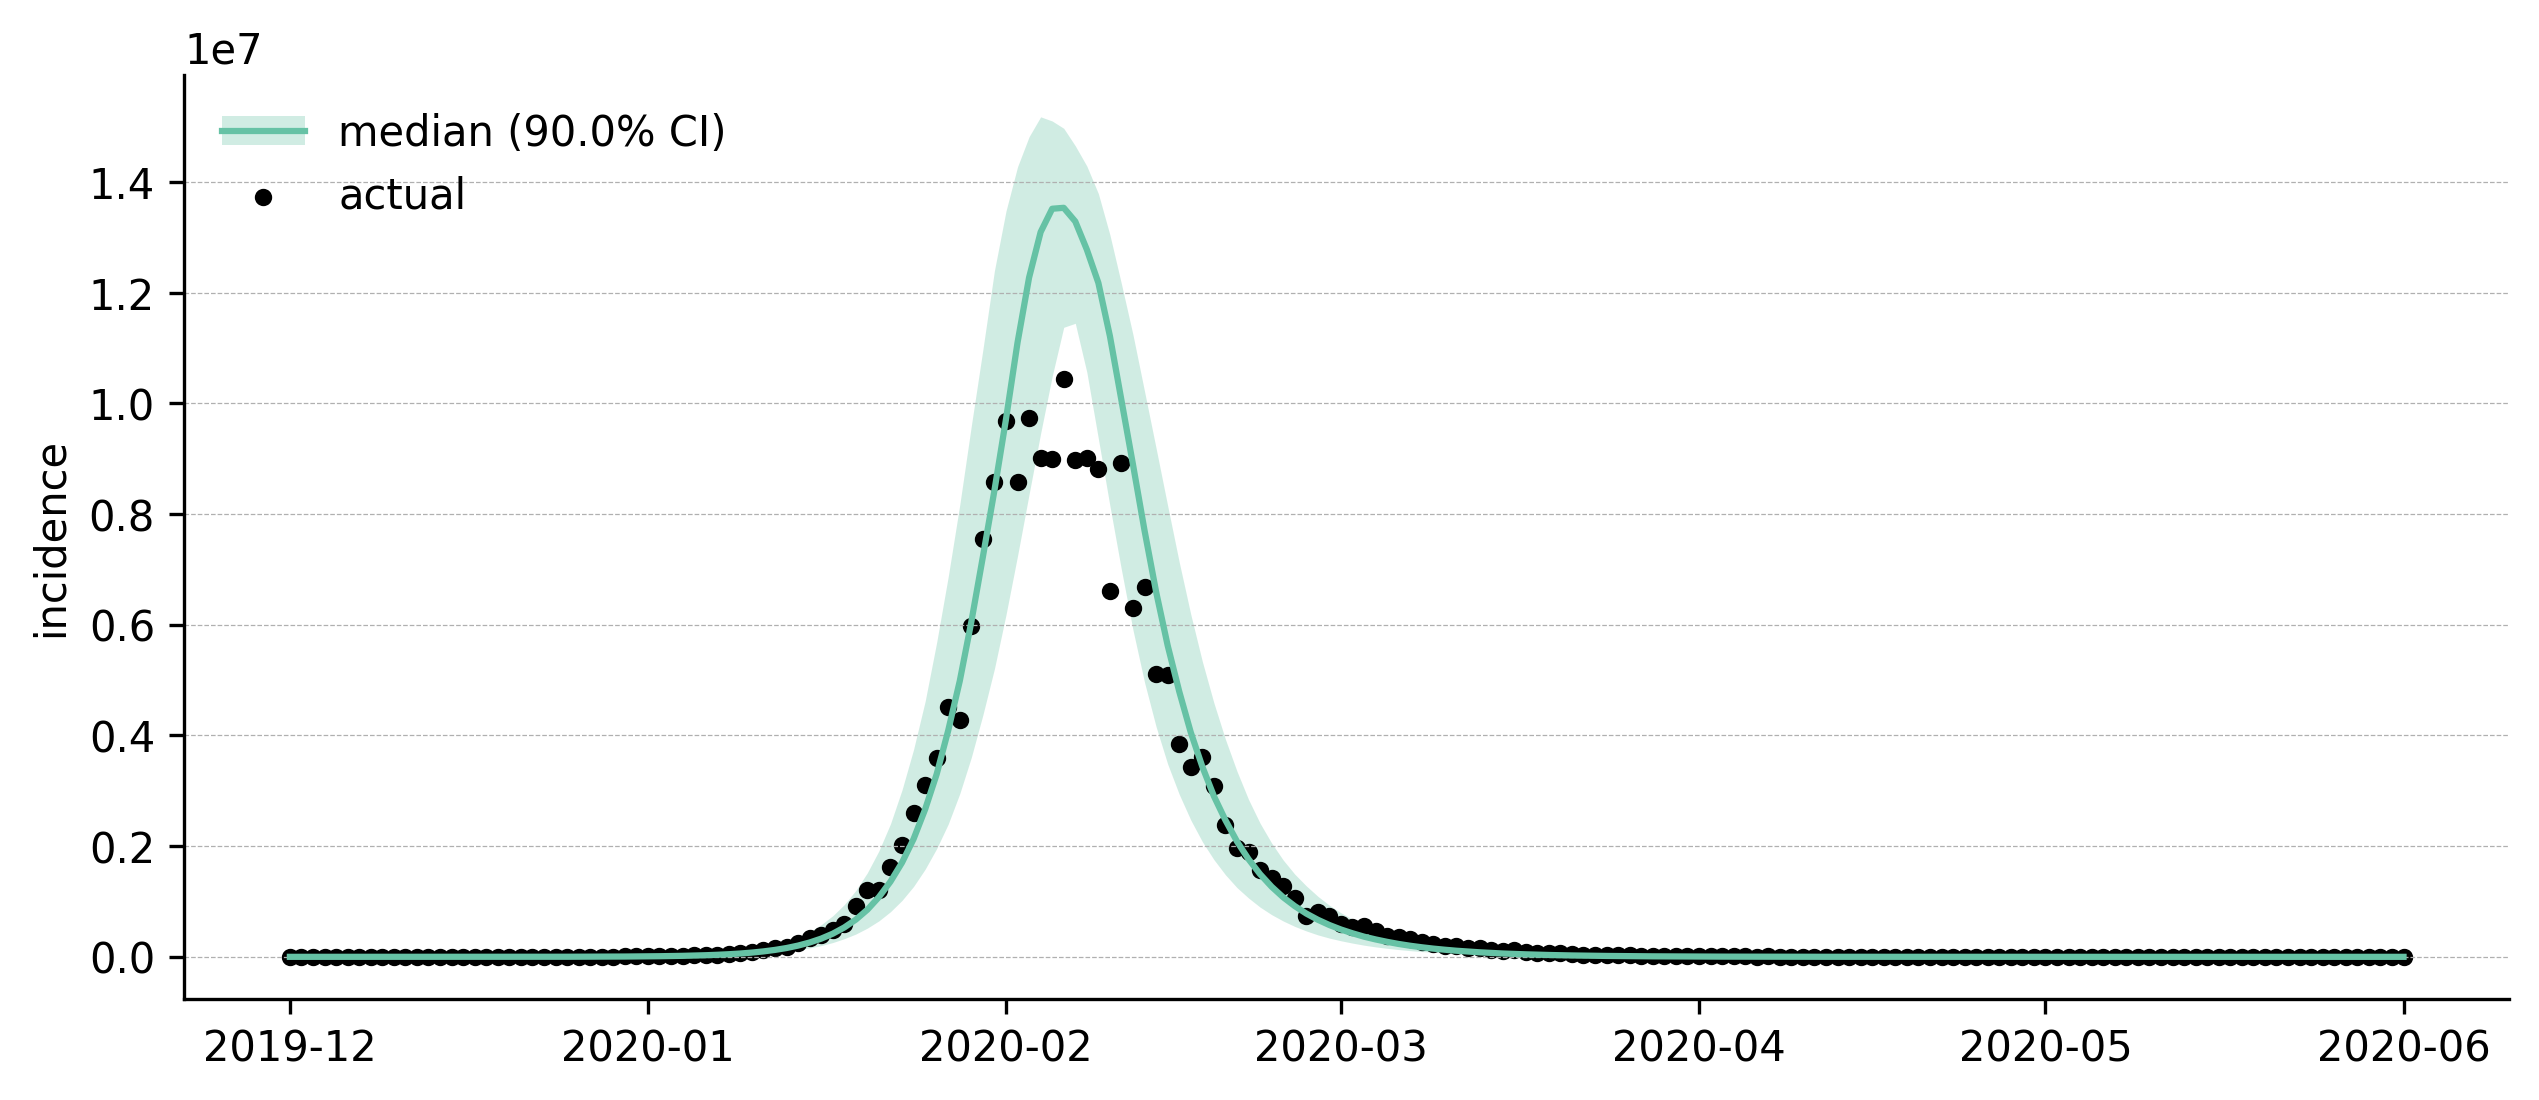

In [12]:
plot_selected_quantiles(results, ylabel="incidence")

# Running Projections

In [ ]:
#results
# run projections

#iterations = 100

#start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
#simulation_dates = pd.date_range(start=start_date, end=end_date, freq="d").tolist()
#model.compute_contact_reductions(population, simulation_dates)
